# Networks of persons in relation to organisations


* Pajek book chapter ...
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/networkx_slicing_with_cores.ipynb) avec simple examples



In [ ]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [3]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [13]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/francesco/kDrive/python_notebooks/astronomers/notebooks_jupyter/wikidata_exploration/../network_analysis_functions.py'>


## Get the data from the triplestore

...  [compléter]


In [ ]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [ ]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                 wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


## Inspect the data


In [ ]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesO']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


### Distribution of relationships in relation to birthYears

In [ ]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

In [ ]:
### We adapt the periods manually
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [ ]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

#### Save dataframe to CSV

In [ ]:
file_add = 'data/persons_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

In [5]:
### load from CSV

file_add = 'data/persons_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

78229


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1921-1940
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,public university | comprehensive university |...,1921-1940


In [6]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1800     2030
1801-1850     4128
1851-1900    10672
1901-1920    10585
1921-1940    18688
1941-1960    19368
1961-1980    10344
1981-2000     2414
dtype: int64


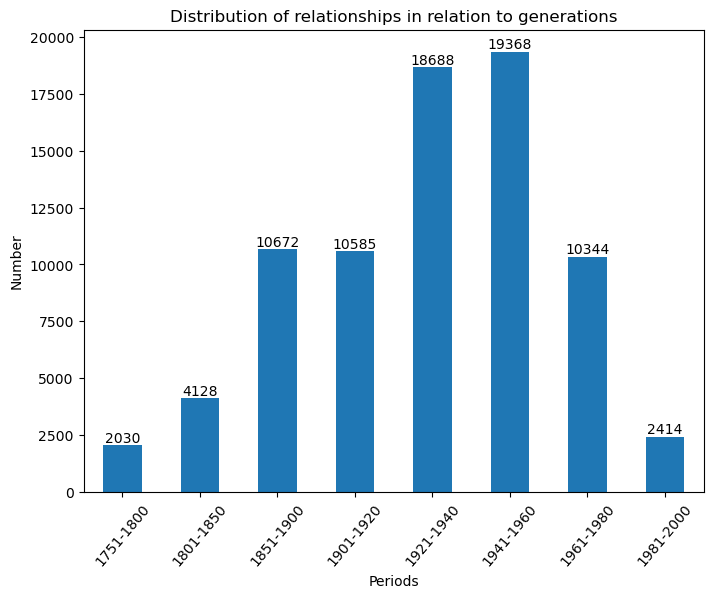

In [7]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Types of organisations

In [ ]:
### convert birthYear to integer
df_p['listTypesO'] = df_p.typesO.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

# decompose in the tokens, unique
df_p['listTokensTypesO'] = df_p.listTypesO.apply(lambda x : sorted(list(set([e for e in (' '.join(x)).split(' ') if len(e) > 2]))))

pprint.pprint(df_p.head().listTypesO.to_list())
print('-----')
pprint.pprint(df_p.head().listTokensTypesO.to_list())

In [ ]:
ll = df_p.listTypesO.to_list()
print(len(ll))
print(ll[:3])

In [ ]:
llj = [' | '.join(b) for b in ll]
print(len(llj))
print(llj[:3])

In [ ]:
ls = pd.Series(llj)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['orgType_group', 'effectif']
ltg.head()


In [ ]:
csv_file='files/network_organisations_types_groups.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

#### Wikidata 'instance of'

In [ ]:
ll = df_p.listTypesO.to_list()
print(len(ll))

In [ ]:
ltt = [a for b in df_p.listTypesO.to_list() for a in b]
print(len(ltt))

In [ ]:
ls = pd.Series(ltt)


In [ ]:
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['organisation', 'effectif']
ltg.head()


In [ ]:
csv_file='files/network_organisations_types.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

#### Wikidata tokens of 'instance of'

In [ ]:
ll = df_p.listTokensTypesO.to_list()
print(len(ll))

In [ ]:
ltt = [a for b in df_p.listTokensTypesO.to_list() for a in b]
print(len(ltt))

In [ ]:
ls = pd.Series(ltt)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['token', 'effectif']
ltg.head()


In [ ]:
csv_file='files/network_organisations_types_tokens.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

### Add education period

In [8]:
### Add constructed education period
df_p['BeginY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 18)
df_p['EndY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 29)
df_p.iloc[5:9]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,BeginY,EndY
5,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,membership,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,1,academy of sciences,1851-1900,NaN,NaN
6,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,education,http://www.wikidata.org/entity/Q3436286,Odense University,1,university,1851-1900,1910.0,1921.0
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1499258,United States Naval Research Laboratory,2,research institute | military unit,1921-1940,NaN,NaN
8,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924,employment,http://www.wikidata.org/entity/Q1410332,National University of Lesotho,1,public university,1921-1940,NaN,NaN


## Create graph for a given period


This is a graph of type 'bipartite', cf. :

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html


We do not use here the functions related to this kind of graph

In [10]:
df_p_1901 = df_p[df_p.periods=='1901-1920'].copy(deep=True)
#pprint.pprint(df_p_1901.head(2).to_dict(orient='records'))

df_p_1961 = df_p[df_p.periods=='1961-1980'].copy(deep=True)
#pprint.pprint(df_p_1961.head(2).to_dict(orient='records'))

df_in_use = df_p_1901


In [11]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer'], e['uriOrg'],
     {'relaType':e['relaType']}
     )) 
     for e in df_in_use.to_dict(orient='records')]
print(len(l))

10585


In [14]:
bip_g = nx.Graph()

bip_g.add_edges_from(l)
naf.basic_graph_properties(bip_g)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 5176,
 'number_of_edges': 9910,
 '------': '------',
 'is connected': False,
 'components': 100,
 'density': 0.0007399442988449104}


In [15]:
### Number of types of relationships
le = list(bip_g.edges.data())
# print([e[2]['relaType'] for e in le][:3]) 
srt = pd.Series([e[2]['relaType'] for e in le])
print(srt.groupby(by=srt).size())

education     3726
employment    3798
membership    2386
dtype: int64


#### Add metadata to nodes

In [21]:
df_p1 = df_in_use[['uriPer','labelPer','birthYear']]
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'birthYear']
df_p1.head(2)

,uri,label,birthYear
60,http://www.wikidata.org/entity/Q100231,Walter Weizel,1901
80,http://www.wikidata.org/entity/Q100281884,Hubert M. James,1908


In [22]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear'],
      'bipartite':0}
     ) for e in df_p1.to_dict(orient='records')])
# print(str(l)[:200])

In [23]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])


[('http://www.wikidata.org/entity/Q100231',
  {'bipartite': 0, 'birthYear': 1901, 'label': 'Walter Weizel'}),
 ('http://www.wikidata.org/entity/Q309988', {}),
 ('http://www.wikidata.org/entity/Q100281884',
  {'bipartite': 0, 'birthYear': 1908, 'label': 'Hubert M. James'})]


In [24]:
df_p2 = df_in_use[['uriOrg','labelOrg']]
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label']
df_p2.head(2)

,uri,label
60,http://www.wikidata.org/entity/Q309988,Karlsruhe Institute of Technology
80,http://www.wikidata.org/entity/Q13371,Harvard University


In [25]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'],
      'bipartite':1}
     ) for e in df_p2.to_dict(orient='records')])
# print(str(l)[:200])

In [26]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])

[('http://www.wikidata.org/entity/Q100231',
  {'bipartite': 0, 'birthYear': 1901, 'label': 'Walter Weizel'}),
 ('http://www.wikidata.org/entity/Q309988',
  {'bipartite': 1, 'label': 'Karlsruhe Institute of Technology'}),
 ('http://www.wikidata.org/entity/Q100281884',
  {'bipartite': 0, 'birthYear': 1908, 'label': 'Hubert M. James'})]


#### Partition 

We can observe that there is one big partition, with approximately 5000 nodes, and around 100 small ones, comprizing 6 nodes or less


We first explore small partitions

In [27]:
### Create a list of graphs, one per component
S = [bip_g.subgraph(c).copy() for c in nx.connected_components(bip_g)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

100
[[0, 4946], [12, 6], [15, 5], [43, 5], [22, 4]]


In [31]:
### 
li = [6, 12, 30]    # [12, 15, 43]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]
pprint.pprint(ll[0][:2])

[('http://www.wikidata.org/entity/Q97279531',
  {'bipartite': 1, 'label': 'Higher School of Pedagogy in Katowice'}),
 ('http://www.wikidata.org/entity/Q521962',
  {'bipartite': 1, 'label': 'Sodality of Our Lady'})]


In [32]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 10,
 'number_of_edges': 7,
 '------': '------',
 'is connected': False,
 'components': 3,
 'density': 0.15555555555555556}


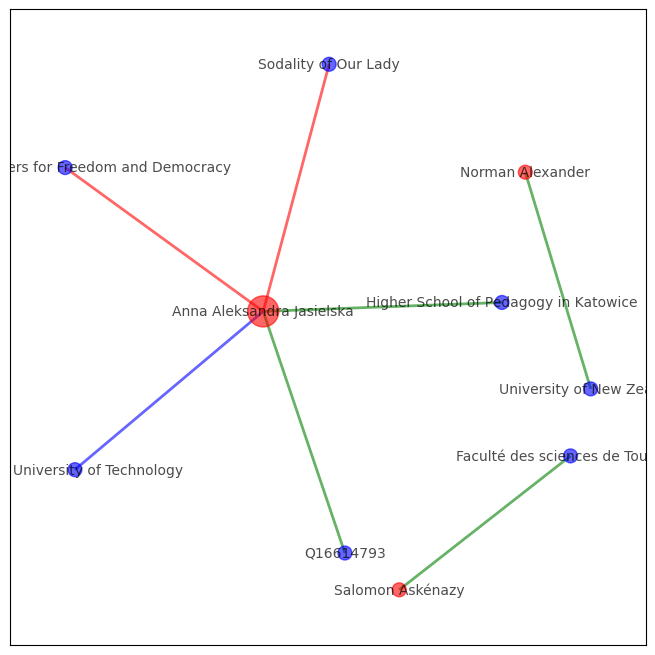

In [33]:
### Plot the graph

g = pG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'kamada_kawai'
n_k = 0.8
sc = 20

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]
edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]


nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, edge_color=edge_colors, width=2, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


#### Biggest component

In [34]:
li = [0]
big_u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_u = nx.union(big_u, S[i])
print(bipartite.is_bipartite(big_u))   
naf.basic_graph_properties(big_u)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 4946,
 'number_of_edges': 9779,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.0007996575349466861}


In [35]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_u)])
nx.set_node_attributes(big_u, degree)
pprint.pprint(list(big_u.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q100231',
  {'bipartite': 0, 'birthYear': 1901, 'degree': 1, 'label': 'Walter Weizel'}),
 ('http://www.wikidata.org/entity/Q309988',
  {'bipartite': 1, 'degree': 9, 'label': 'Karlsruhe Institute of Technology'})]


In [36]:
### Add eivenvalue to nodes
eigenvector = nx.eigenvector_centrality(big_u, max_iter=300)
nx.set_node_attributes(big_u, eigenvector, 'eigenvector')
pprint.pprint(list(big_u.nodes.data())[1:3])

[('http://www.wikidata.org/entity/Q309988',
  {'bipartite': 1,
   'degree': 9,
   'eigenvector': 0.0005316171471272166,
   'label': 'Karlsruhe Institute of Technology'}),
 ('http://www.wikidata.org/entity/Q100281884',
  {'bipartite': 0,
   'birthYear': 1908,
   'degree': 3,
   'eigenvector': 0.003806964033678901,
   'label': 'Hubert M. James'})]


In [37]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number

core_numbers = nx.core_number(big_u)
print(str(core_numbers)[:150])

{'http://www.wikidata.org/entity/Q100231': 1, 'http://www.wikidata.org/entity/Q309988': 3, 'http://www.wikidata.org/entity/Q100281884': 2, 'http://www


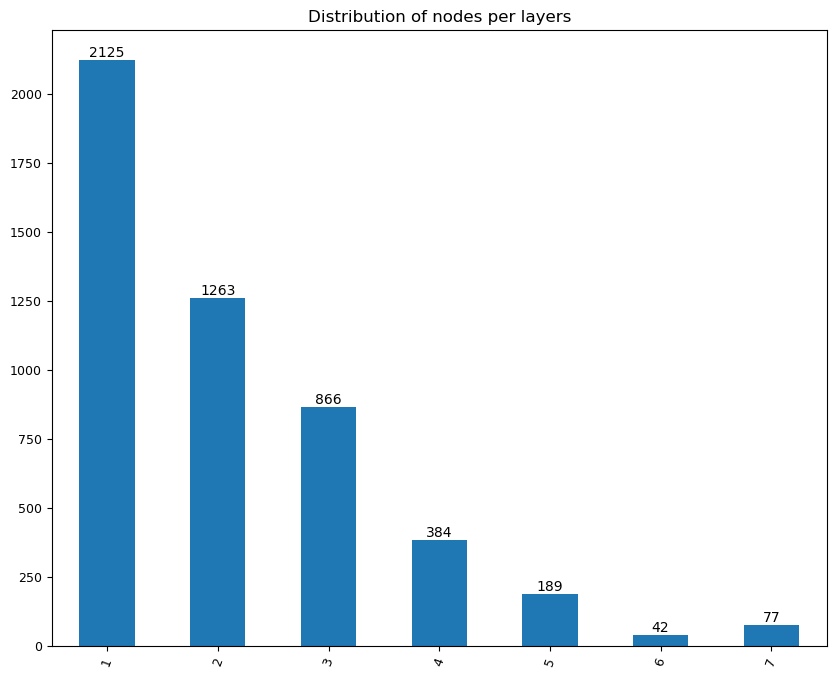

In [38]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8))
plt.title('Distribution of nodes per layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [39]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



Community 1: 2125, ['http://www.wikidata.org/entity/Q100231', 'http://www.wikidata.org/entity/Q7291901', 'http://www.wikidata.org/entity/Q100348038', 'http://www.wikidata.org/entity/Q20055490', 'http://www.wikidata.org/entity/Q1122926']
Community 3: 866, ['http://www.wikidata.org/entity/Q309988', 'http://www.wikidata.org/entity/Q875788', 'http://www.wikidata.org/entity/Q122453', 'http://www.wikidata.org/entity/Q101195671', 'http://www.wikidata.org/entity/Q1067935']
Community 2: 1263, ['http://www.wikidata.org/entity/Q100281884', 'http://www.wikidata.org/entity/Q100369077', 'http://www.wikidata.org/entity/Q214654', 'http://www.wikidata.org/entity/Q1004776', 'http://www.wikidata.org/entity/Q1115639']
Community 7: 77, ['http://www.wikidata.org/entity/Q13371', 'http://www.wikidata.org/entity/Q49088', 'http://www.wikidata.org/entity/Q49108', 'http://www.wikidata.org/entity/Q131252', 'http://www.wikidata.org/entity/Q49112']
Community 4: 384, ['http://www.wikidata.org/entity/Q217741', 'http:/

In [40]:
cts=sorted(cts, key=lambda x: x[0])
p=[pprint.pprint([e[0],e[1],e[2][:3] ]) for e in cts]

[1,
 2125,
 ['http://www.wikidata.org/entity/Q100231',
  'http://www.wikidata.org/entity/Q7291901',
  'http://www.wikidata.org/entity/Q100348038']]
[2,
 1263,
 ['http://www.wikidata.org/entity/Q100281884',
  'http://www.wikidata.org/entity/Q100369077',
  'http://www.wikidata.org/entity/Q214654']]
[3,
 866,
 ['http://www.wikidata.org/entity/Q309988',
  'http://www.wikidata.org/entity/Q875788',
  'http://www.wikidata.org/entity/Q122453']]
[4,
 384,
 ['http://www.wikidata.org/entity/Q217741',
  'http://www.wikidata.org/entity/Q390287',
  'http://www.wikidata.org/entity/Q209842']]
[5,
 189,
 ['http://www.wikidata.org/entity/Q459506',
  'http://www.wikidata.org/entity/Q193727',
  'http://www.wikidata.org/entity/Q379848']]
[6,
 42,
 ['http://www.wikidata.org/entity/Q49738',
  'http://www.wikidata.org/entity/Q104607',
  'http://www.wikidata.org/entity/Q2095524']]
[7,
 77,
 ['http://www.wikidata.org/entity/Q13371',
  'http://www.wikidata.org/entity/Q49088',
  'http://www.wikidata.org/entity/Q4

In [41]:
### get all nodes with 
ln = [ k  for k,v in core_numbers.items()  if v >= 6]
print(len(ln), ln[:2])

119 ['http://www.wikidata.org/entity/Q13371', 'http://www.wikidata.org/entity/Q49088']


In [42]:
cG = big_u.subgraph(ln)
naf.basic_graph_properties(cG)
pprint.pprint(list(cG.nodes.data())[:1])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 119,
 'number_of_edges': 642,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.09143996581683521}
[('http://www.wikidata.org/entity/Q148109',
  {'bipartite': 0,
   'birthYear': 1910,
   'degree': 14,
   'eigenvector': 0.053756286094498784,
   'label': 'Subrahmanyan Chandrasekhar'})]


In [43]:
### Same result by using the k_core function
kc_G = nx.k_core(big_u, 6)
naf.basic_graph_properties(kc_G)
pprint.pprint(list(kc_G.nodes.data())[:1])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 119,
 'number_of_edges': 642,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.09143996581683521}
[('http://www.wikidata.org/entity/Q148109',
  {'bipartite': 0,
   'birthYear': 1910,
   'degree': 14,
   'eigenvector': 0.053756286094498784,
   'label': 'Subrahmanyan Chandrasekhar'})]


count    119.000000
mean      10.789916
std       10.056513
min        6.000000
25%        7.000000
50%        8.000000
75%       10.000000
max       76.000000
dtype: float64


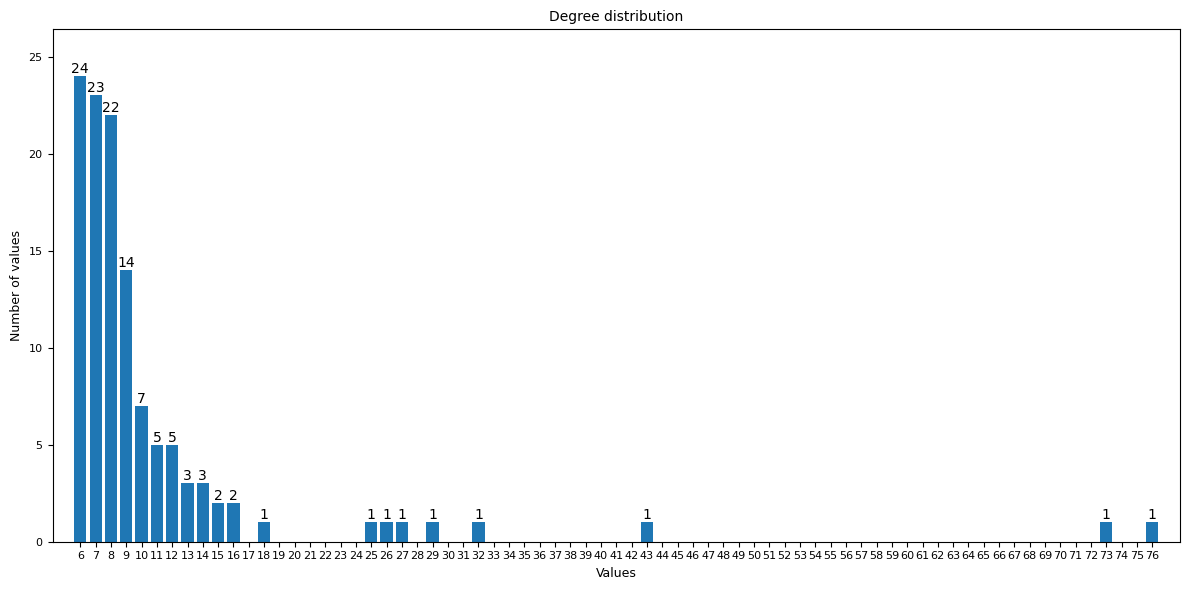

In [44]:
### Plot degree distribution
d = [d[1] for d in nx.degree(kc_G)]
naf.describe_plot_integers_distribution(d, 12,6,'Degree distribution')

In [ ]:
### 

g = kc_G

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 50 #*25

graph_layout = 'spring_layout'
n_k = 0.5
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_bipartite_component_test.svg')
plt.close()
#plt.plot()

#### Explore the degree centrality and eigenvector

In [45]:
export = pd.DataFrame(kc_G.nodes.data(), columns = ['id', 'attributes'])
attributes = pd.json_normalize(export.attributes)

export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)
round(attributes, 3)
export.head(2)
#pprint.pprint(list(nd[:3]))

,label,birthYear,bipartite,degree,eigenvector
id,,,,,
http://www.wikidata.org/entity/Q148109,Subrahmanyan Chandrasekhar,1910.0,0,14,0.053756
http://www.wikidata.org/entity/Q107419,Norman Foster Ramsey,1915.0,0,13,0.056979


In [46]:
### Most frequent persons/organisations by degree or eigenvector (replace in the sort clause !)
## The degree is definitely higher for universities, but the eigenvector can also be high for persons
# and this insofar as they studied in high-degree institutions
export.sort_values(by='eigenvector', ascending=False)[['label', 'bipartite', 'degree', 'eigenvector']].iloc[:20]

,label,bipartite,degree,eigenvector
id,,,,
http://www.wikidata.org/entity/Q270794,National Academy of Sciences,1,257,0.416168
http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,1,247,0.413192
http://www.wikidata.org/entity/Q123885,Royal Society,1,168,0.174841
http://www.wikidata.org/entity/Q2370801,Academy of Sciences of the USSR,1,157,0.097034
http://www.wikidata.org/entity/Q543804,German Academy of Sciences Leopoldina,1,90,0.093938
http://www.wikidata.org/entity/Q466113,American Physical Society,1,58,0.090571
http://www.wikidata.org/entity/Q49108,Massachusetts Institute of Technology,1,112,0.090084
http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",1,108,0.088938
http://www.wikidata.org/entity/Q13371,Harvard University,1,110,0.083683


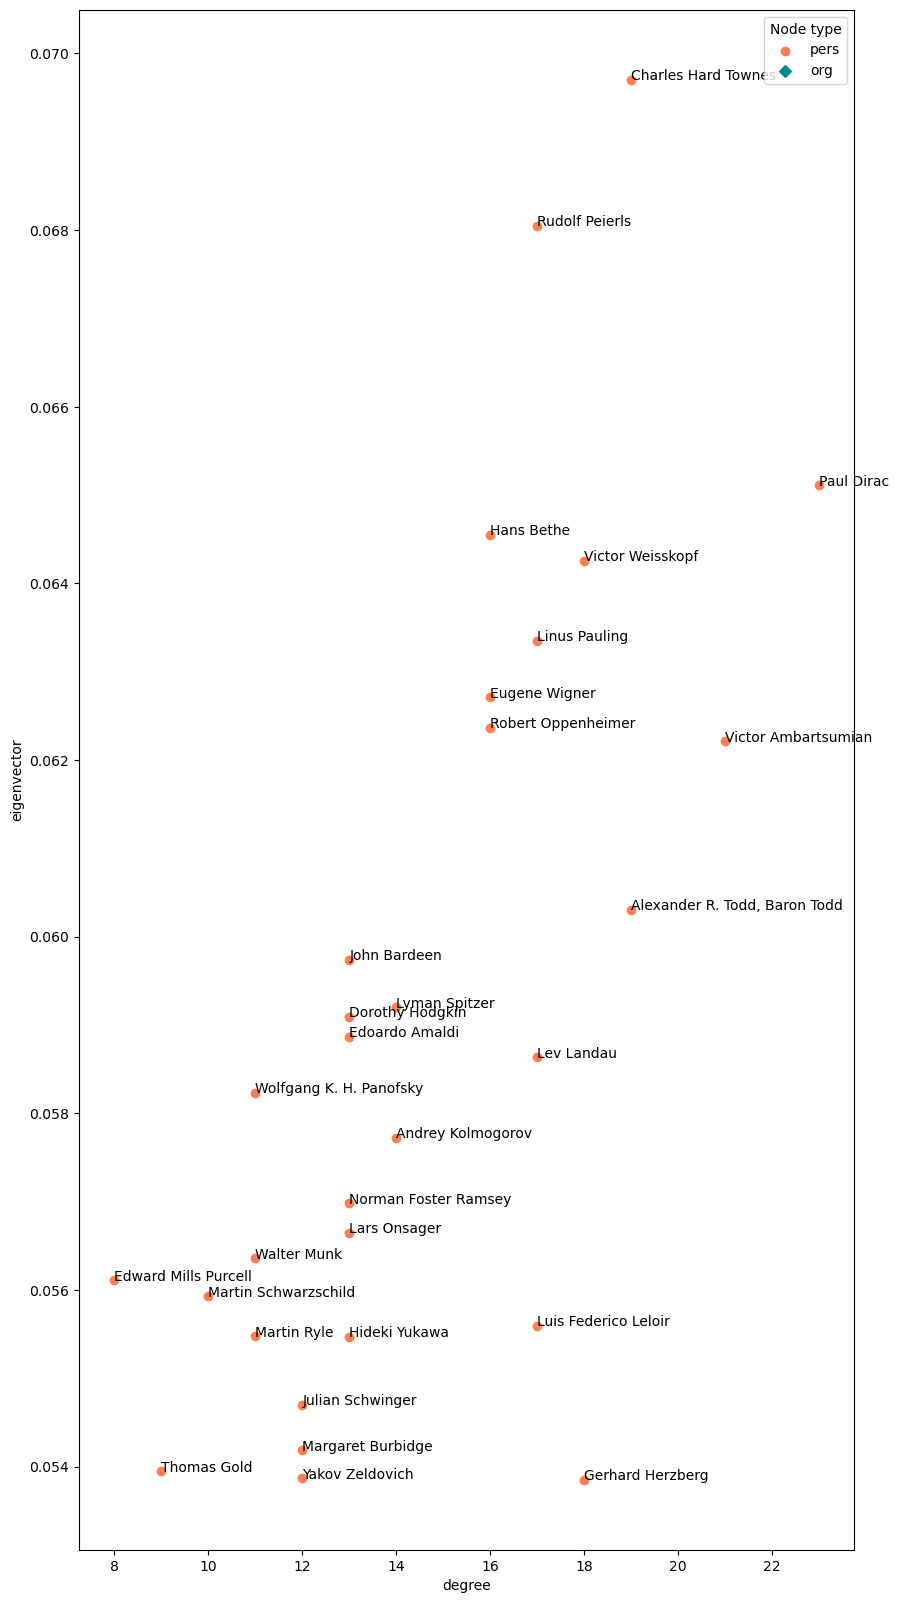

In [47]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==0].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

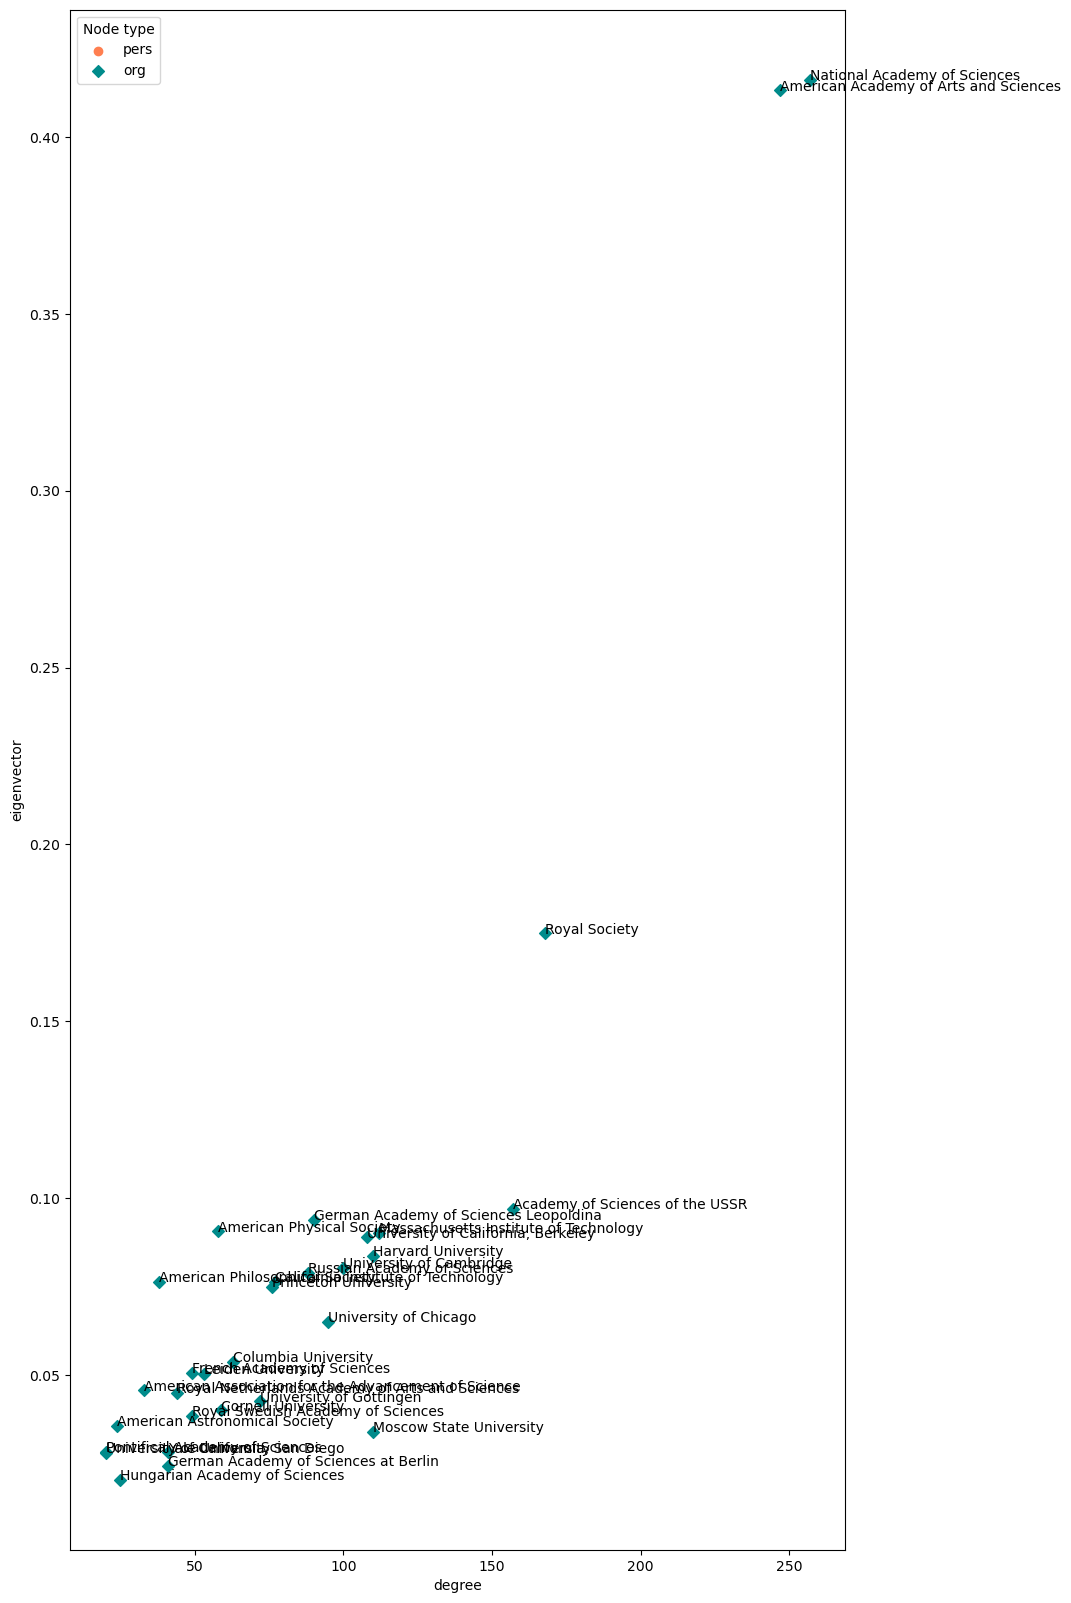

In [48]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==1].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

## Create graph of persons relationships during studies

In [49]:
print(list(df_p.columns))
df_p.head(2)

['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes', 'typesO', 'periods', 'BeginY', 'EndY']


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,BeginY,EndY
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,membership,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,2,academy of sciences | building,1921-1940,NaN,NaN
1,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,education,http://www.wikidata.org/entity/Q153978,University of Tübingen,6,public university | comprehensive university |...,1921-1940,1947.0,1958.0


### Prepare and create the graph

In [50]:
### Select the columns that will be used
df_sel = df_p[df_p.relaType=='education'][['uriPer','uriOrg', 'labelOrg', 'BeginY','EndY', 'periods']].copy(deep=True)
print(len(df_sel))

29294


In [51]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_sel, df_sel, on=['uriOrg', 'labelOrg'])
print(len(merged))


3344010


In [52]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriPer_x'] < (merged['uriPer_y'])]
print(len(merged))

1657358


In [53]:
### Restrict time overlap (allow only 8 years overlap) — could be extended to have a larger result
merged = merged[(merged['BeginY_y']+2 < merged['EndY_x']-2) & (merged['BeginY_x']+2 < merged['EndY_y']-2)]
print(len(merged))
merged = merged[['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x',  'BeginY_y', 'EndY_y', 'periods_y']]



239517


In [132]:
print(len(merged))
print(list(merged.columns))
merged.head()

239517
['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']


,uriPer_x,uriPer_y,uriOrg,labelOrg,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
1,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q100212,http://www.wikidata.org/entity/Q153978,University of Tübingen,1921-1940,1947.0,1958.0,1951.0,1962.0,1921-1940
8,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q102239054,http://www.wikidata.org/entity/Q153978,University of Tübingen,1921-1940,1947.0,1958.0,1952.0,1963.0,1921-1940
18,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q102931598,http://www.wikidata.org/entity/Q153978,University of Tübingen,1921-1940,1947.0,1958.0,1942.0,1953.0,1921-1940
25,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q118363,http://www.wikidata.org/entity/Q153978,University of Tübingen,1921-1940,1947.0,1958.0,1949.0,1960.0,1921-1940
27,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q13422604,http://www.wikidata.org/entity/Q153978,University of Tübingen,1921-1940,1947.0,1958.0,1953.0,1964.0,1921-1940


In [133]:
### Group by persons' pairs and count/aggregate organisations

## This is needed because the nx.add_edges_from() function applies
# a DISTINCT approach and information will be lost if two persons
# are related by more than one organisation 

gr_mer = merged.groupby(['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y'], as_index = False)\
    .agg({'labelOrg': '|'.join, 'uriOrg': '|'.join})
gr_mer['number'] = gr_mer.labelOrg.apply(lambda x : len(x.split('|')))
print(len(gr_mer))


236467


In [134]:
### change columns names
gr_mer.columns= ['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y', 'orgs', 'uriOrgs', 'numberOrgs']

In [135]:
### change columns positions
gr_mer = gr_mer[['uriPer_x', 'uriPer_y', 'orgs', 'numberOrgs', 'uriOrgs', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']]
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q100212,University of Tübingen,1,http://www.wikidata.org/entity/Q153978,1921-1940,1947.0,1958.0,1951.0,1962.0,1921-1940
1,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q102239054,University of Tübingen,1,http://www.wikidata.org/entity/Q153978,1921-1940,1947.0,1958.0,1952.0,1963.0,1921-1940


In [137]:
### Store the information from the SPARQL query in a CSV file
# in order to be able to upload it witout executing the query again
file_add = 'data/persons_common_education.csv'
try:
    gr_mer.to_csv(file_add)
    print('Written!')
except Exception as e:
    print(e)


Written!


In [58]:
### sort by multiple relationships
gr_mer[['uriPer_x','uriPer_y','orgs','numberOrgs']].sort_values(by='numberOrgs', ascending=False).iloc[:7]

,uriPer_x,uriPer_y,orgs,numberOrgs
117535,http://www.wikidata.org/entity/Q181369,http://www.wikidata.org/entity/Q183679,Tsinghua University|Peking University|National...,5
232196,http://www.wikidata.org/entity/Q742536,http://www.wikidata.org/entity/Q9095,University of Cambridge|Peterhouse|Edinburgh A...,4
29259,http://www.wikidata.org/entity/Q11168306,http://www.wikidata.org/entity/Q16090553,"University College of Science, Technology & Ag...",3
24400,http://www.wikidata.org/entity/Q109588,http://www.wikidata.org/entity/Q3170446,University of Paris|Lycée Louis-le-Grand|École...,3
127661,http://www.wikidata.org/entity/Q197941,http://www.wikidata.org/entity/Q202152,Massachusetts Institute of Technology|Stanford...,3
155184,http://www.wikidata.org/entity/Q24960980,http://www.wikidata.org/entity/Q507732,Harvard University|Massachusetts Institute of ...,3
183943,http://www.wikidata.org/entity/Q377898,http://www.wikidata.org/entity/Q45789,Presidency University|Hindu School|University ...,3


In [59]:
### store multiple relationships in order to explore them in the CSV
file_add = 'data/persons_education_rel_multiple.csv'
gr_mer[gr_mer.numberOrgs > 1].sort_values(by='numberOrgs', ascending=False).to_csv(file_add)

#### Example of connected persons

Displayed with **Allegrograph Gruff**

<img src="images/alg_gruff_example_chinese_connected_education.png" alt="drawing" width="700"/>

In [60]:
### Find persons in different periods

## We observe that there is significant overlap: more than 30000
# Periods are as a matter of fact an artificial construct !

print(len(gr_mer[gr_mer.periods_x != gr_mer.periods_y]))
gr_mer[gr_mer.periods_x != gr_mer.periods_y].sort_values(by='numberOrgs', ascending=False).iloc[:5]

33936


,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
127661,http://www.wikidata.org/entity/Q197941,http://www.wikidata.org/entity/Q202152,Massachusetts Institute of Technology|Stanford...,3,http://www.wikidata.org/entity/Q49108|http://w...,1961-1980,1981.0,1992.0,1977.0,1988.0,1941-1960
24400,http://www.wikidata.org/entity/Q109588,http://www.wikidata.org/entity/Q3170446,University of Paris|Lycée Louis-le-Grand|École...,3,http://www.wikidata.org/entity/Q209842|http://...,1941-1960,1962.0,1973.0,1958.0,1969.0,1921-1940
71985,http://www.wikidata.org/entity/Q132537,http://www.wikidata.org/entity/Q234909,Harvard University|University of Cambridge,2,http://www.wikidata.org/entity/Q13371|http://w...,1901-1920,1922.0,1933.0,1918.0,1929.0,1851-1900
72025,http://www.wikidata.org/entity/Q132537,http://www.wikidata.org/entity/Q562321,University of Cambridge|Jesus College,2,http://www.wikidata.org/entity/Q35794|http://w...,1901-1920,1922.0,1933.0,1916.0,1927.0,1851-1900
163473,http://www.wikidata.org/entity/Q28055166,http://www.wikidata.org/entity/Q2897032,Weizmann Institute of Science|Hebrew Universit...,2,http://www.wikidata.org/entity/Q4182|http://ww...,1941-1960,1959.0,1970.0,1956.0,1967.0,1921-1940


### Create the graph

In [61]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer.to_dict(orient='records')]
print(len(l))

236467


In [62]:
print(len(gr_mer))

236467


In [63]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 17634,
 'number_of_edges': 236467,
 '------': '------',
 'is connected': False,
 'components': 432,
 'density': 0.001520979964766358}


#### Add metadata to nodes

In [64]:
df_pm = df_p[['uriPer','labelPer','birthYear']]
df_pm = df_pm.drop_duplicates()
df_pm.columns=['uri', 'label', 'birthYear']
df_pm.head()


,uri,label,birthYear
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929
3,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892
7,http://www.wikidata.org/entity/Q100153910,Frank J. Blatt,1924
17,http://www.wikidata.org/entity/Q100155322,Edgar Knobloch,1953
20,http://www.wikidata.org/entity/Q100157315,Ding Jing,1924


In [65]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [66]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1000193',
  {'birthYear': 1929, 'label': 'Hans Elsässer'}),
 ('http://www.wikidata.org/entity/Q100212',
  {'birthYear': 1933, 'label': 'Peter Kramer'})]


## Explore the education relationships graph

In [67]:
naf.basic_graph_properties(ppG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 17634,
 'number_of_edges': 236467,
 '------': '------',
 'is connected': False,
 'components': 432,
 'density': 0.001520979964766358}


#### Components

In [68]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

[[0, 16201], [117, 26], [23, 25], [165, 24], [44, 22]]


### Explore small graph

In [69]:
### 
li = [117]    # [12, 15, 43]
ll = [list(perS[i[0]].nodes.data()) for i in ln if i[0] in li ]
#pprint.pprint(str(ll)[:300])

In [70]:

# Display variable

u_117 = nx.Graph()

for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u_117 = nx.union(u_117, perS[i])
naf.basic_graph_properties(u_117)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 26,
 'number_of_edges': 143,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.44}


{'http://www.wikidata.org/entity/Q26466124': 'Vladimir Harutyunyan', 'http://www.wikidata.org/entity/Q15623610': 'Q15623610', 'http://www.wikidata.org/entity/Q131455242': 'Lotsko Dina V.', 'http://www.wikidata.org/entity/Q24229543': 'Ella Kaganovich', 'http://www.wikidata.org/entity/Q25441810': 'Q25441810', 'http://www.wikidata.org/entity/Q21153276': 'Q21153276', 'http://www.wikidata.org/entity/Q17426891': 'I. M. T︠S︡idilʹkovskiĭ', 'http://www.wikidata.org/entity/Q28701923': 'Yuri Naydich', 'http://www.wikidata.org/entity/Q16701828': 'Q16701828', 'http://www.wikidata.org/entity/Q20066521': 'George Gogotsi', 'http://www.wikidata.org/entity/Q21683455': 'Borys Bondarenko', 'http://www.wikidata.org/entity/Q60827462': 'Q60827462', 'http://www.wikidata.org/entity/Q12151203': 'Sergei V. Svechnikov', 'http://www.wikidata.org/entity/Q28702510': 'Q28702510', 'http://www.wikidata.org/entity/Q19910796': 'Yuriy Meshkov', 'http://www.wikidata.org/entity/Q12174221': 'Q12174221', 'http://www.wikidata.

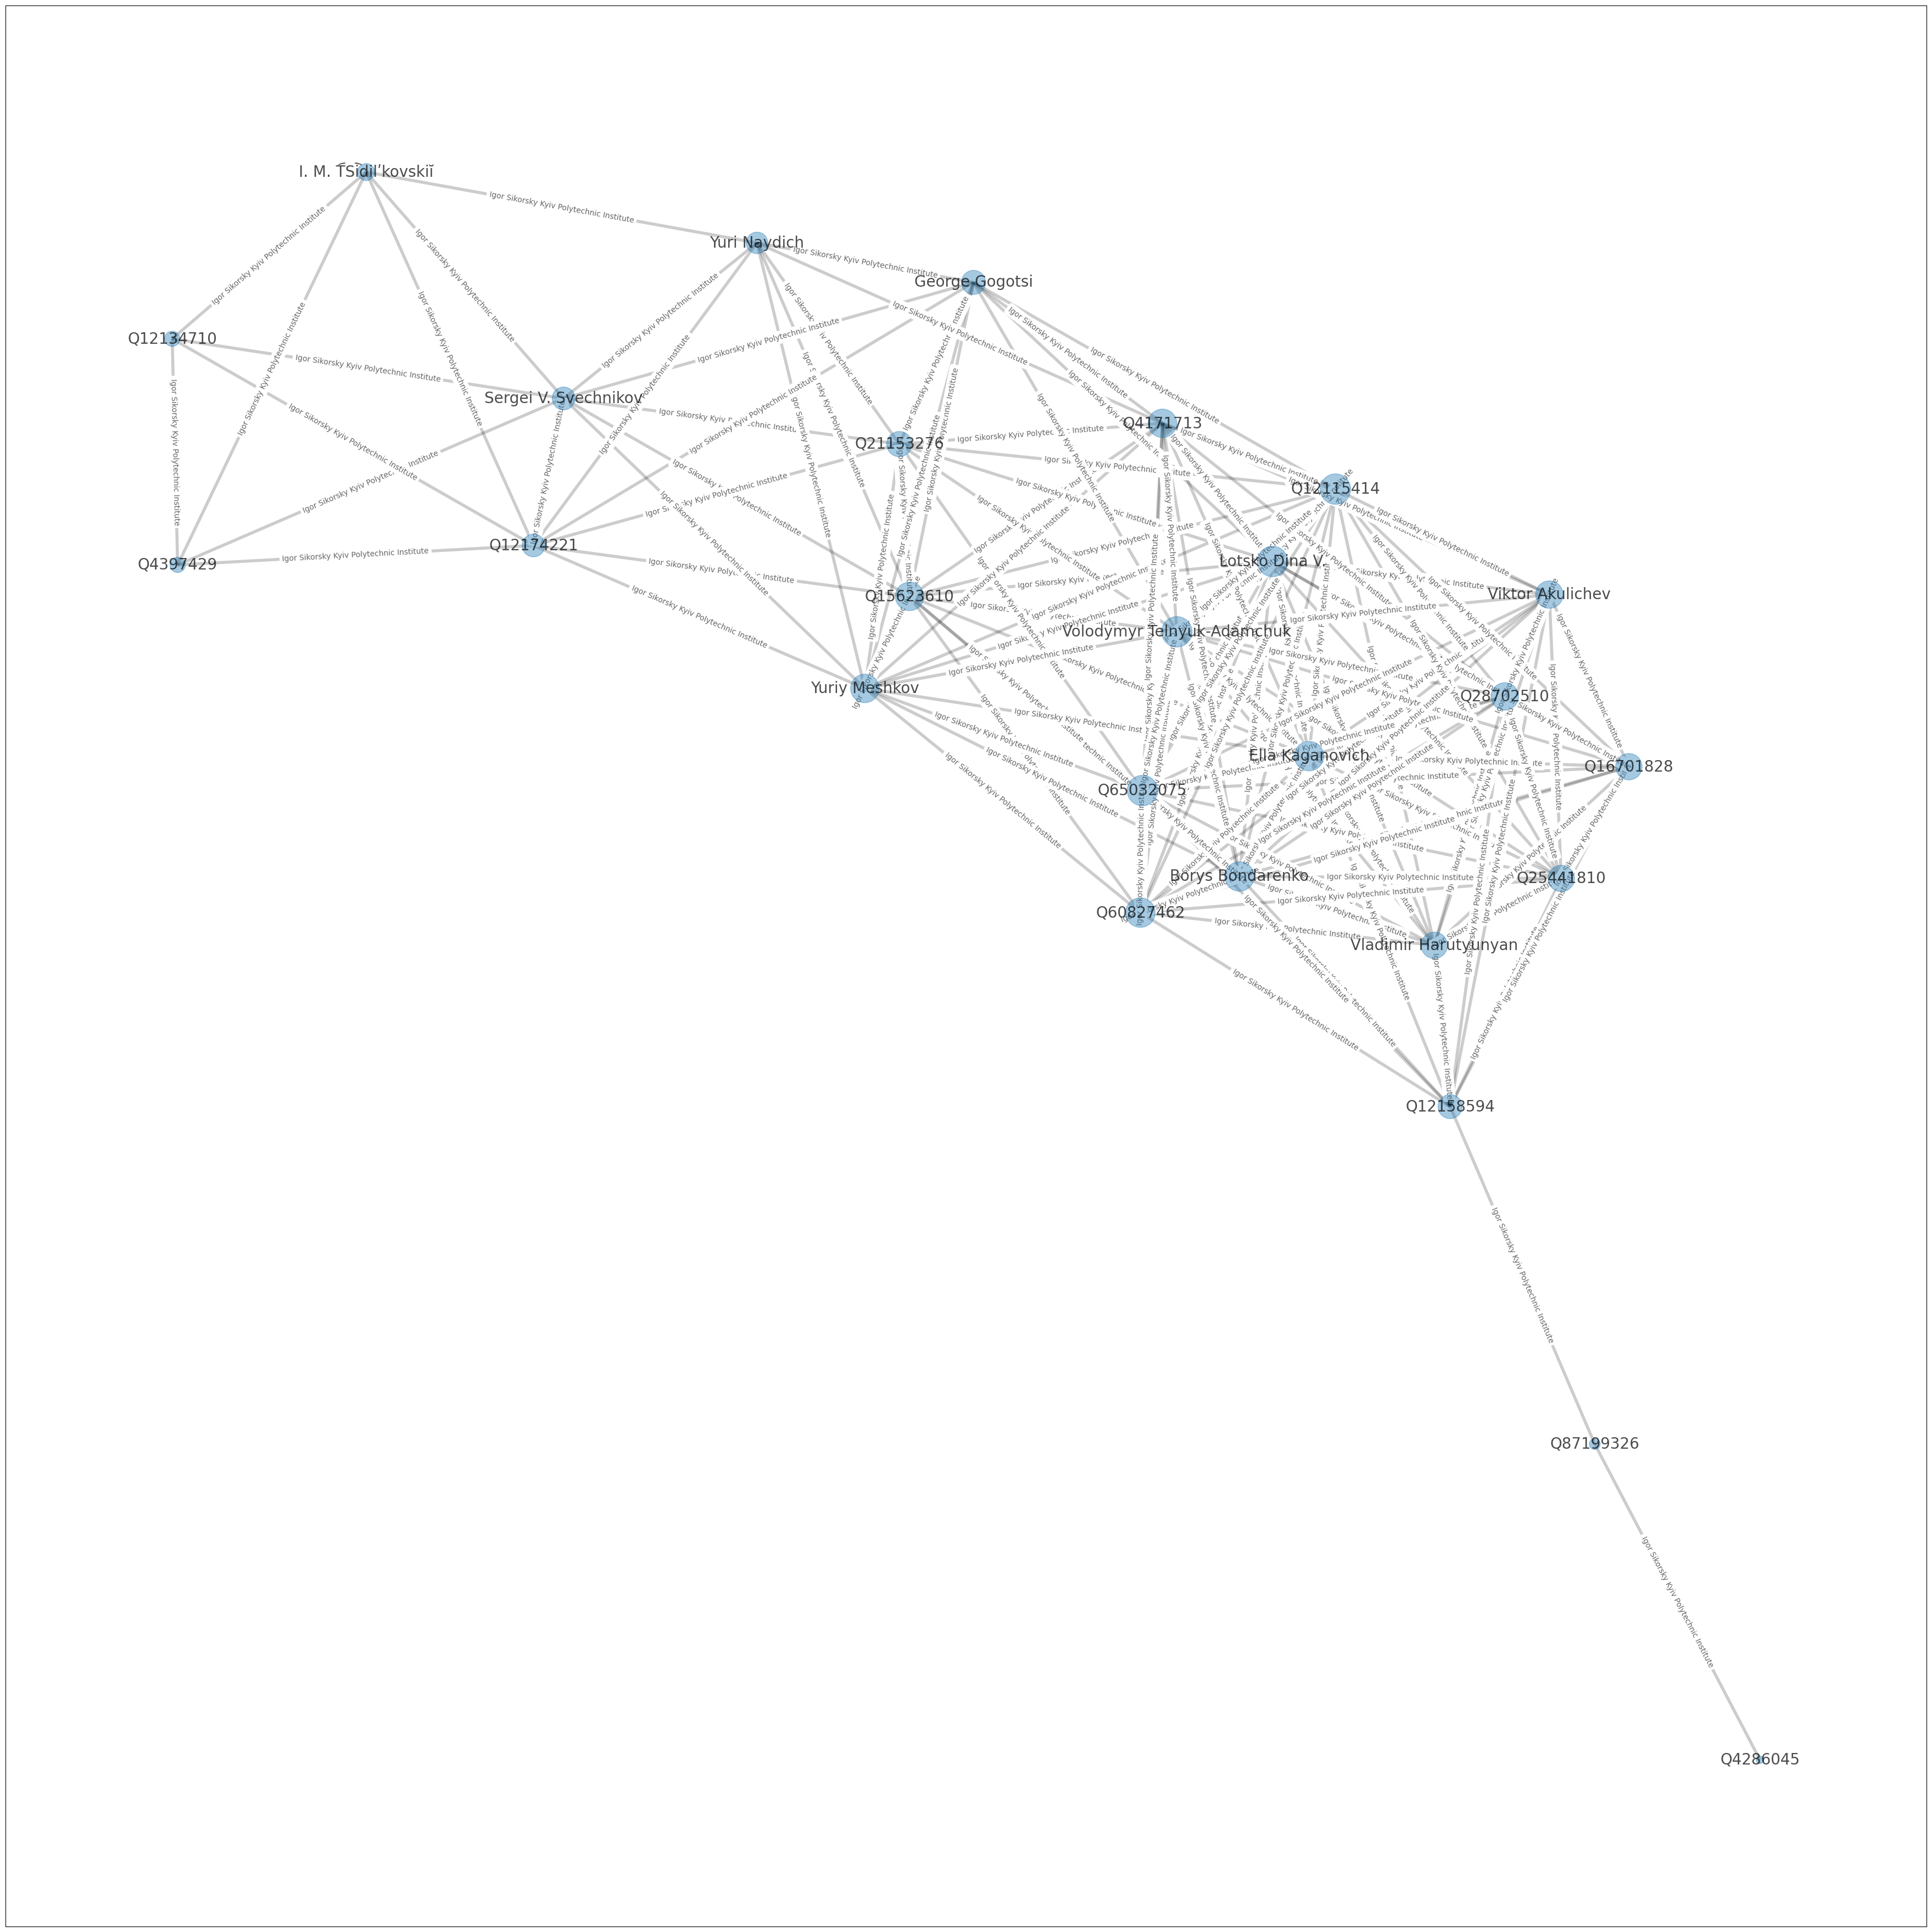

In [71]:
### 

g = u_117

# print(list(g.nodes.data())[:3])
# print(list(g.edges.data())[:3])

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 30 #*25

graph_layout = 'kamada_kawai'
n_k = 0.4
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
print(node_labels)
edge_labels = {e: g.get_edge_data(e[0], e[1])["orgsLabels"] for e in g.edges()}
print(edge_labels)


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_size=node_size, alpha=0.4)
nx.draw_networkx_edges(g, pos, label=edge_labels, width=4, alpha=0.2) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, alpha=0.6)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


In [ ]:
df_p[(df_p.labelOrg.str.contains('Kyiv Poly'))& df_p.relaType.str.contains('educa')].head()

#### Composante principale

In [72]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 16201,
 'number_of_edges': 234496,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.001786934353236845}


In [73]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000193',
  {'birthYear': 1929, 'label': 'Hans Elsässer'}),
 ('http://www.wikidata.org/entity/Q100212',
  {'birthYear': 1933, 'label': 'Peter Kramer'})]


In [74]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)
pprint.pprint(list(big_ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1000193',
  {'birthYear': 1929, 'degree': 12, 'label': 'Hans Elsässer'}),
 ('http://www.wikidata.org/entity/Q100212',
  {'birthYear': 1933, 'degree': 29, 'label': 'Peter Kramer'})]


### Degree distribution and slicing

count    16201.000000
mean        28.948337
std         33.519854
min          1.000000
25%          7.000000
50%         16.000000
75%         37.000000
max        276.000000
dtype: float64


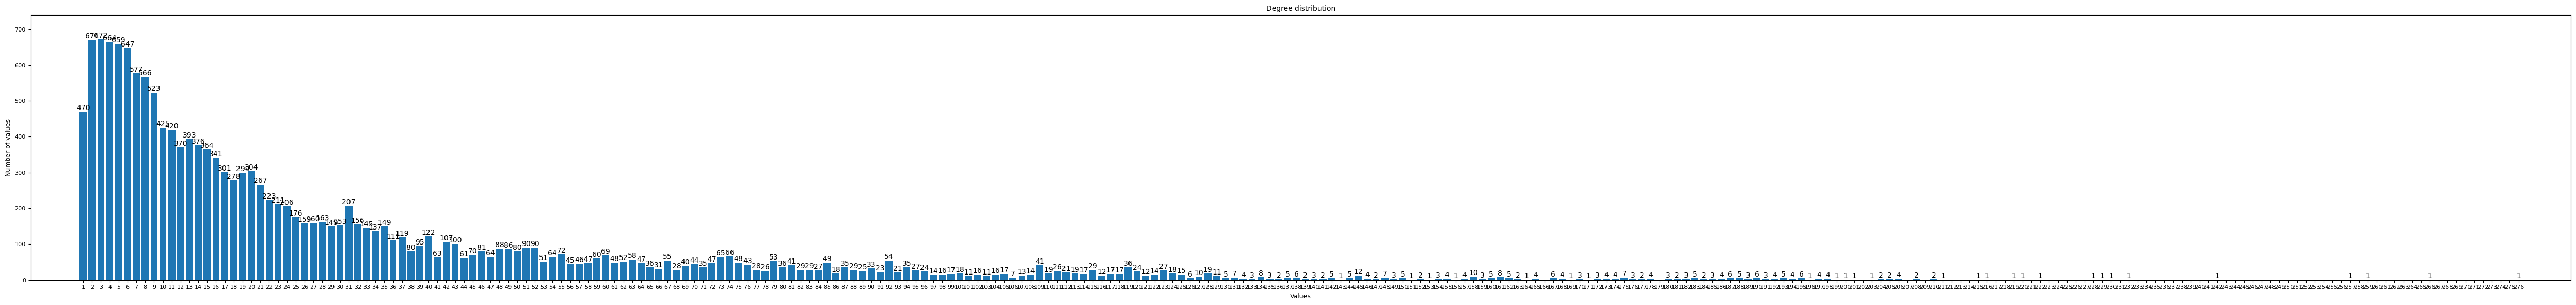

In [75]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [76]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000193',
  {'birthYear': 1929,
   'degree': 12,
   'eigenvector': 9.139357064274719e-07,
   'label': 'Hans Elsässer'}),
 ('http://www.wikidata.org/entity/Q100212',
  {'birthYear': 1933,
   'degree': 29,
   'eigenvector': 2.7247304232171406e-06,
   'label': 'Peter Kramer'})]


In [77]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    16201.00000000000000000000
mean         0.00193013625360966283
std          0.00761595293706997419
min          0.00000000000000000000
25%          0.00000000243091631769
50%          0.00000154054754345634
75%          0.00013610493515402787
max          0.08754391373006004118
dtype: object


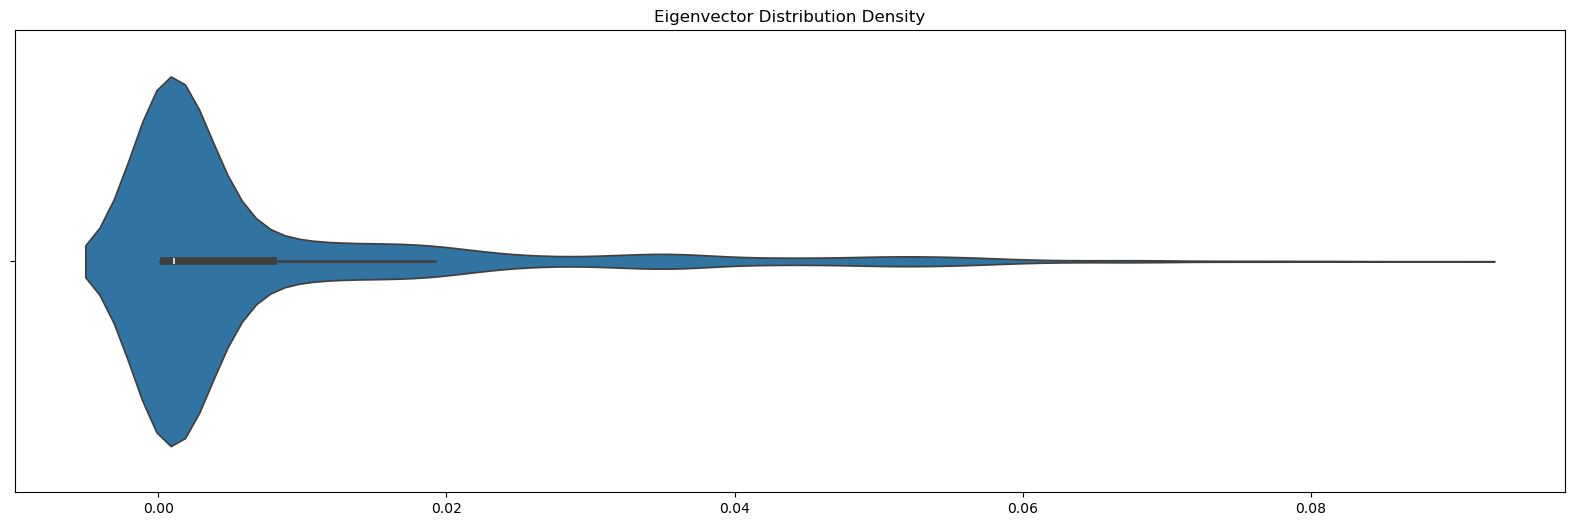

In [78]:
# Plot the distribution of eigenvector density

plt.figure(figsize=(20, 6))
p = sns.violinplot(data=eigenvector_s[eigenvector_s> 0.00013610493515402787], orient='h')
plt.title('Eigenvector Distribution Density')
plt.show()

In [ ]:
print(len(eigenvector_s[eigenvector_s> 0.01]))

In [79]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,12,0.000001
1,http://www.wikidata.org/entity/Q100212,Peter Kramer,1933,29,0.000003


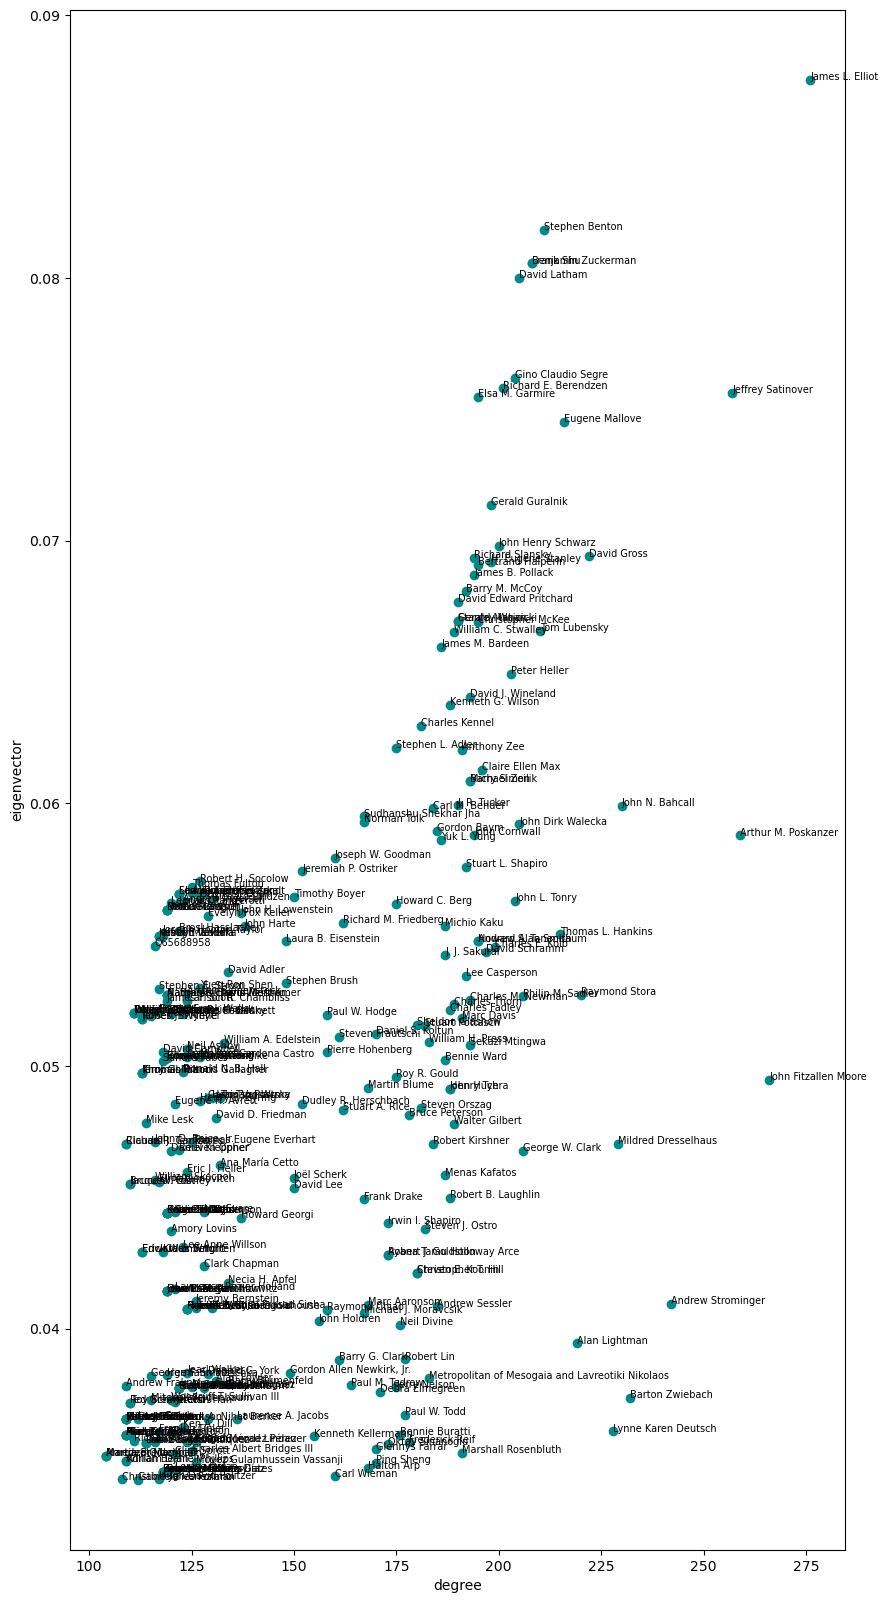

In [80]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [81]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

910 ['http://www.wikidata.org/entity/Q102123746', 'http://www.wikidata.org/entity/Q103152807', 'http://www.wikidata.org/entity/Q103232929']


In [82]:
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q100212,University of Tübingen,1,http://www.wikidata.org/entity/Q153978,1921-1940,1947.0,1958.0,1951.0,1962.0,1921-1940
1,http://www.wikidata.org/entity/Q1000193,http://www.wikidata.org/entity/Q102239054,University of Tübingen,1,http://www.wikidata.org/entity/Q153978,1921-1940,1947.0,1958.0,1952.0,1963.0,1921-1940


In [84]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
file_add='data/connecting_orgs.csv'
connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
Harvard University                         17312
Massachusetts Institute of Technology      15290
University of California, Berkeley          6813
Princeton University                        5809
California Institute of Technology          5667
Cornell University                          3540
Stanford University                         1181
Columbia University                         1071
University of Chicago                        700
University of Cambridge                      491
Yale University                              404
University of Michigan                       173
University of California, Los Angeles        151
University of Illinois Urbana–Champaign      142
Stony Brook University                       133
University of Pennsylvania                   119
University of Rochester                      118
University of Wisconsin–Madison              116
University of Texas at Austin                107
Harvard College                              106
dtype: int64


### Slicing with cores

In [85]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

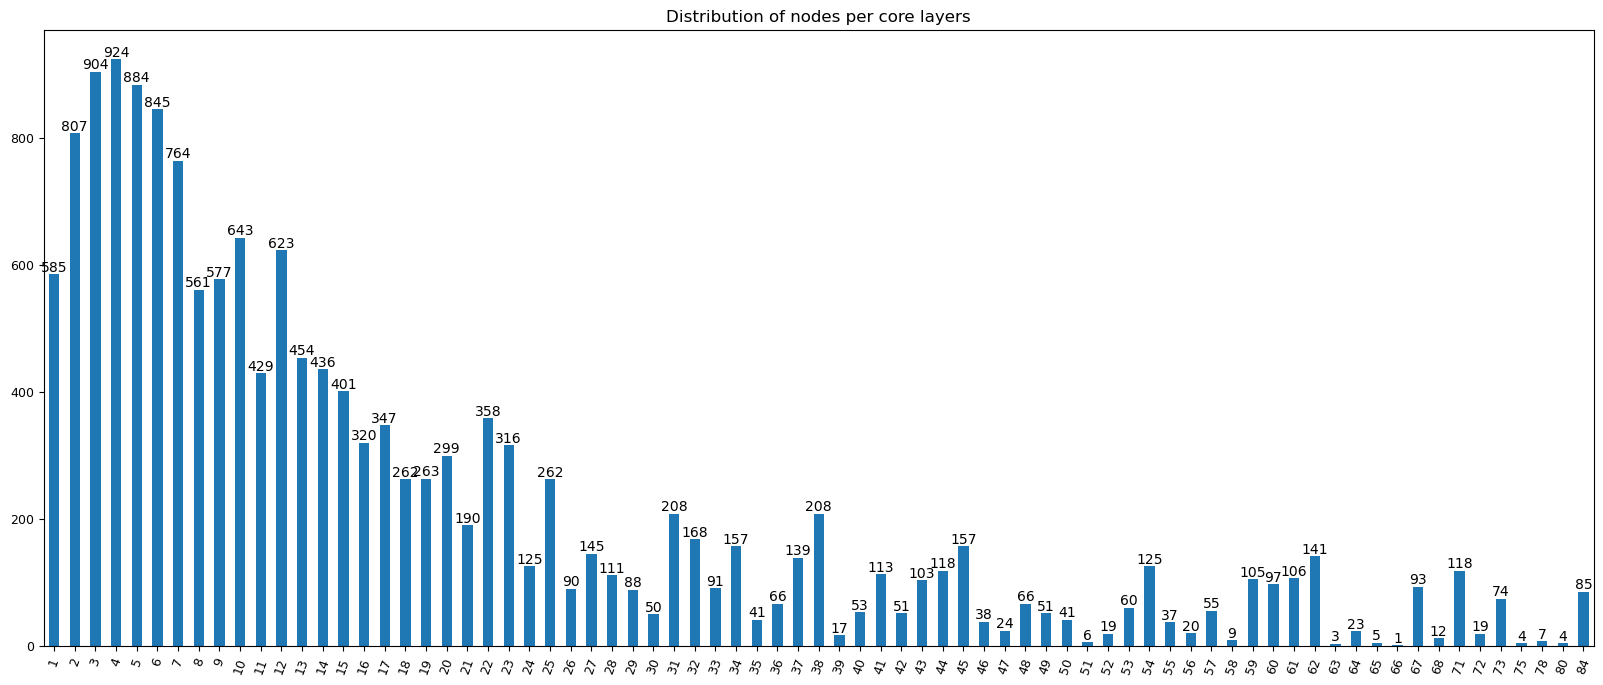

In [86]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [87]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    # print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



In [88]:
cts=sorted(cts, key=lambda x: x[0])
pprint.pprint([[e[0], e[1] ] for e in cts])

[[1, 585],
 [2, 807],
 [3, 904],
 [4, 924],
 [5, 884],
 [6, 845],
 [7, 764],
 [8, 561],
 [9, 577],
 [10, 643],
 [11, 429],
 [12, 623],
 [13, 454],
 [14, 436],
 [15, 401],
 [16, 320],
 [17, 347],
 [18, 262],
 [19, 263],
 [20, 299],
 [21, 190],
 [22, 358],
 [23, 316],
 [24, 125],
 [25, 262],
 [26, 90],
 [27, 145],
 [28, 111],
 [29, 88],
 [30, 50],
 [31, 208],
 [32, 168],
 [33, 91],
 [34, 157],
 [35, 41],
 [36, 66],
 [37, 139],
 [38, 208],
 [39, 17],
 [40, 53],
 [41, 113],
 [42, 51],
 [43, 103],
 [44, 118],
 [45, 157],
 [46, 38],
 [47, 24],
 [48, 66],
 [49, 51],
 [50, 41],
 [51, 6],
 [52, 19],
 [53, 60],
 [54, 125],
 [55, 37],
 [56, 20],
 [57, 55],
 [58, 9],
 [59, 105],
 [60, 97],
 [61, 106],
 [62, 141],
 [63, 3],
 [64, 23],
 [65, 5],
 [66, 1],
 [67, 93],
 [68, 12],
 [71, 118],
 [72, 19],
 [73, 74],
 [75, 4],
 [78, 7],
 [80, 4],
 [84, 85]]


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v >= 65]
print(len(ln), ln[:3])

In [90]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 422,
 'number_of_edges': 21291,
 '------': '------',
 'is connected': False,
 'components': 2,
 'density': 0.23967984149677476}


In [91]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(SG)
nx.set_node_attributes(SG, betweenness, 'betweenness')
pprint.pprint(list(SG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q472382',
  {'betweenness': 8.961349249787347e-05,
   'birthYear': 1928,
   'degree': 128,
   'eigenvector': 0.03775623117181483,
   'label': 'Sam Edwards'}),
 ('http://www.wikidata.org/entity/Q530123',
  {'betweenness': 0.002243716125041177,
   'birthYear': 1932,
   'degree': 120,
   'eigenvector': 0.04676978840205822,
   'label': 'Daniel Kleppner'})]


In [92]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_test.svg')
plt.close()
#plt.plot()

## New graphs by period 

In [ ]:
gr_mer.head(2)

### Period 1851-1900

In [93]:
gr_mer_1851_1900 = gr_mer[(gr_mer.periods_x=='1851-1900')|(gr_mer.periods_y=='1851-1900')].copy(deep=True)
len(gr_mer_1851_1900)

19502

In [94]:
### Distribution of relationships number
print(gr_mer_1851_1900.groupby(by='numberOrgs').size())

numberOrgs
1    19137
2      352
3       13
dtype: int64


In [95]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1851_1900.to_dict(orient='records')]
print(len(l))

19502


In [96]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2822,
 'number_of_edges': 19502,
 '------': '------',
 'is connected': False,
 'components': 64,
 'density': 0.004899469429315569}


In [97]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [98]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q100456',
  {'birthYear': 1855, 'label': 'Wilhelm Kohlrausch'}),
 ('http://www.wikidata.org/entity/Q1348051',
  {'birthYear': 1852, 'label': 'Erasmus Kittler'})]


In [99]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



[[0, 2630], [40, 15], [18, 8], [27, 8], [49, 6]]


In [100]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2630,
 'number_of_edges': 19309,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.005585260627658451}


In [101]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


count    2630.000000
mean       14.683650
std        15.225986
min         1.000000
25%         4.000000
50%         9.000000
75%        20.000000
max       129.000000
dtype: float64


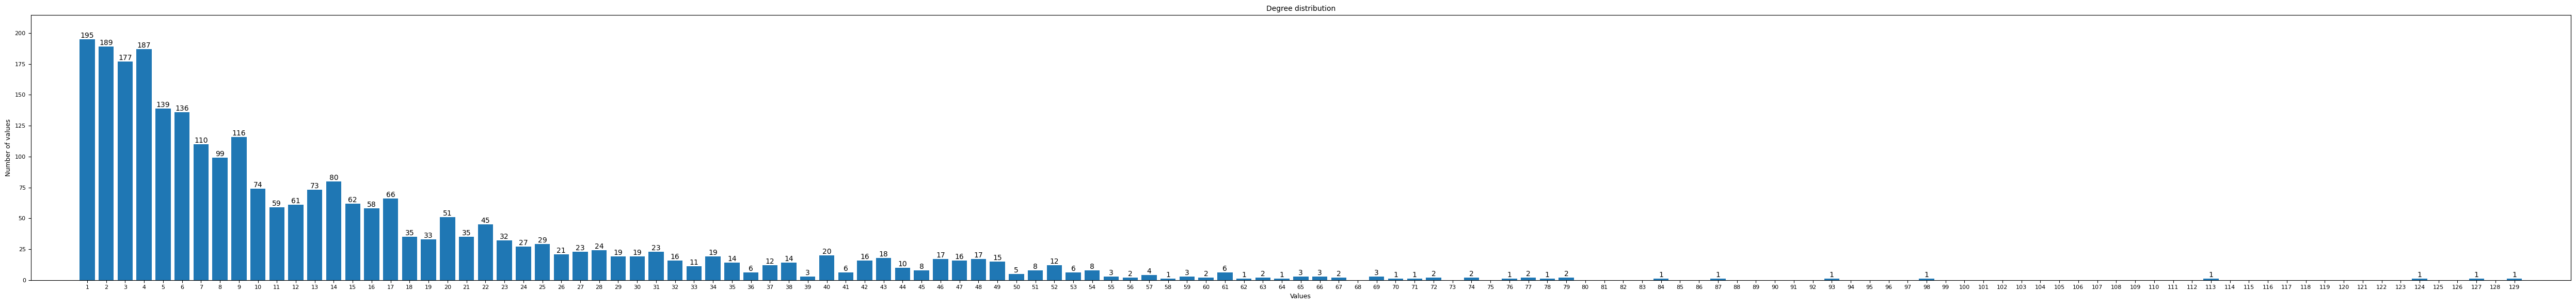

In [102]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [103]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q100456',
  {'birthYear': 1855,
   'degree': 3,
   'eigenvector': 4.821866305039021e-06,
   'label': 'Wilhelm Kohlrausch'}),
 ('http://www.wikidata.org/entity/Q1348051',
  {'birthYear': 1852,
   'degree': 2,
   'eigenvector': 2.000027290377479e-07,
   'label': 'Erasmus Kittler'})]


In [104]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    2630.00000000000000000000
mean        0.00521137915671034992
std         0.01879372135186750323
min         0.00000000000000000002
25%         0.00000601189669138609
50%         0.00007617577477181332
75%         0.00083392854996291793
max         0.18667709007369229224
dtype: object


In [105]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector
0,http://www.wikidata.org/entity/Q100456,Wilhelm Kohlrausch,1855,3,0.000005
1,http://www.wikidata.org/entity/Q1348051,Erasmus Kittler,1852,2,0.0


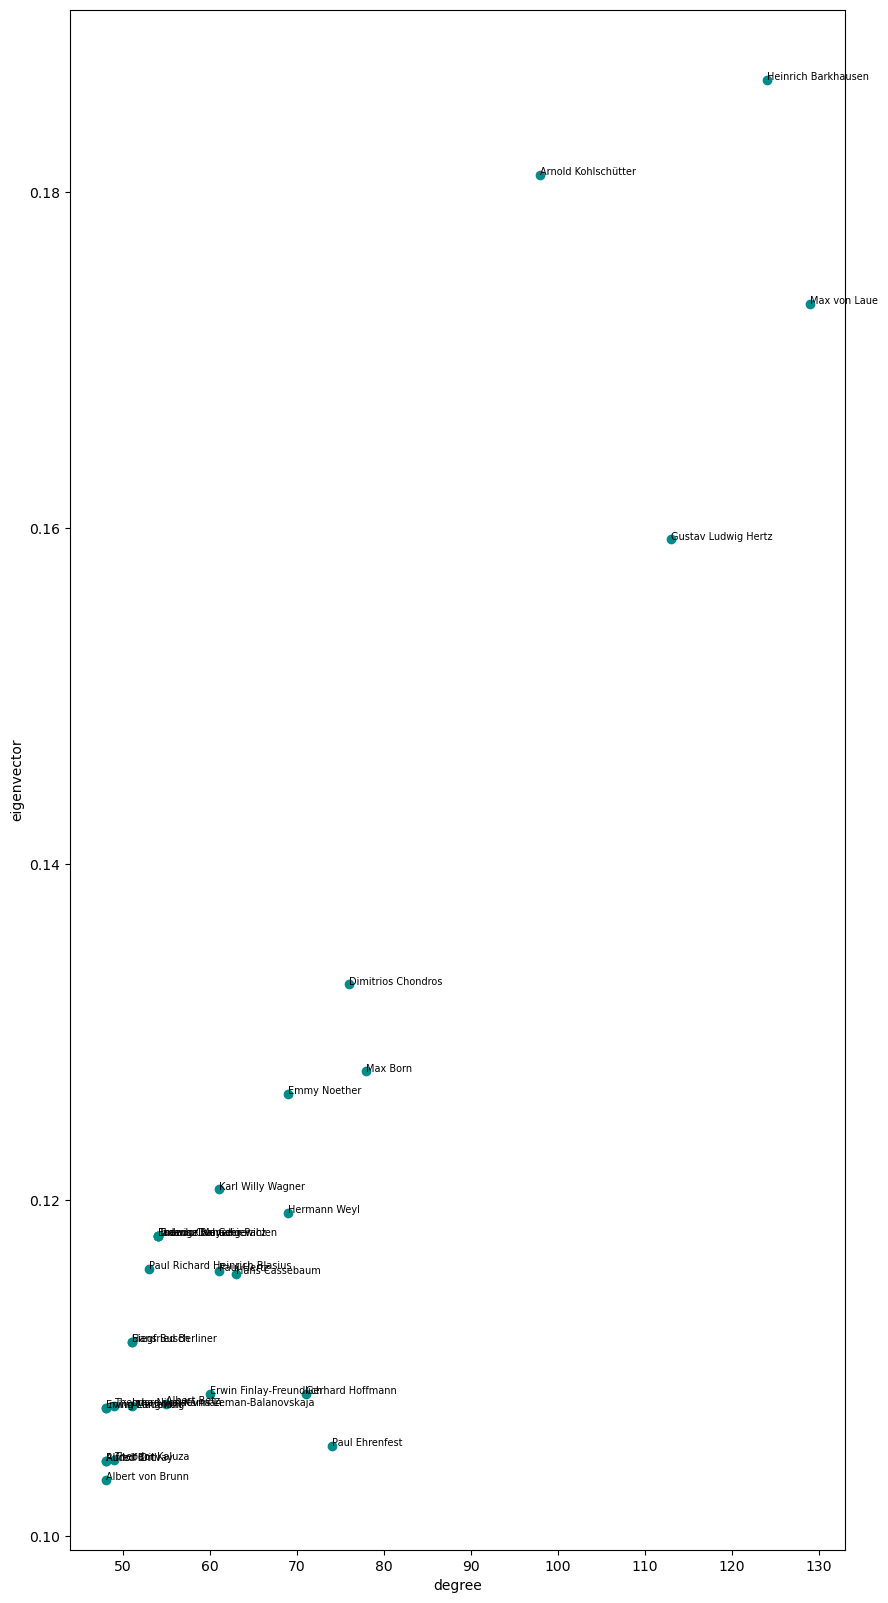

In [106]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [107]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

231 ['http://www.wikidata.org/entity/Q364062', 'http://www.wikidata.org/entity/Q94404', 'http://www.wikidata.org/entity/Q57075']


In [108]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
University of Göttingen                                             2437
Humboldt University of Berlin                                       1661
Ludwig-Maximilian-University in Munich                               615
Heidelberg University                                                147
Leipzig University                                                   136
Technische Universität Berlin                                         76
Harvard University                                                    51
University of Vienna                                                  50
University of Paris                                                   46
Technical University of Munich                                        38
Massachusetts Institute of Technology                                 29
University of Zurich                                                  24
ETH Zurich                                                            22
University of Bonn                            

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')


In [141]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q100456',
  {'betweenness': 0.0003802280268148326,
   'birthYear': 1855,
   'degree': 3,
   'eigenvector': 4.821866305039021e-06,
   'label': 'Wilhelm Kohlrausch'}),
 ('http://www.wikidata.org/entity/Q1348051',
  {'betweenness': 0.0,
   'birthYear': 1852,
   'degree': 2,
   'eigenvector': 2.000027290377479e-07,
   'label': 'Erasmus Kittler'})]


In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q100456,Wilhelm Kohlrausch,1855,3,0.000005,0.00038
1,http://www.wikidata.org/entity/Q1348051,Erasmus Kittler,1852,2,0.0,0.0


In [144]:
nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]

,personUri,label,birthYear,degree,eigenvector,betweenness
296,http://www.wikidata.org/entity/Q60264,Heinrich Barkhausen,1881,124,0.186677,0.022723
304,http://www.wikidata.org/entity/Q83617,Arnold Kohlschütter,1883,98,0.181011,0.020632
294,http://www.wikidata.org/entity/Q57067,Max von Laue,1879,129,0.173341,0.049259
329,http://www.wikidata.org/entity/Q57070,Gustav Ludwig Hertz,1887,113,0.159325,0.03183
322,http://www.wikidata.org/entity/Q12876062,Dimitrios Chondros,1882,76,0.132835,0.009704
351,http://www.wikidata.org/entity/Q58978,Max Born,1882,78,0.127658,0.022917
353,http://www.wikidata.org/entity/Q7099,Emmy Noether,1882,69,0.126324,0.008205
406,http://www.wikidata.org/entity/Q108239,Karl Willy Wagner,1883,61,0.120634,0.01197
334,http://www.wikidata.org/entity/Q71029,Hermann Weyl,1885,69,0.119236,0.014675
449,http://www.wikidata.org/entity/Q81202,Theodor Meyer,1882,54,0.117878,0.003278


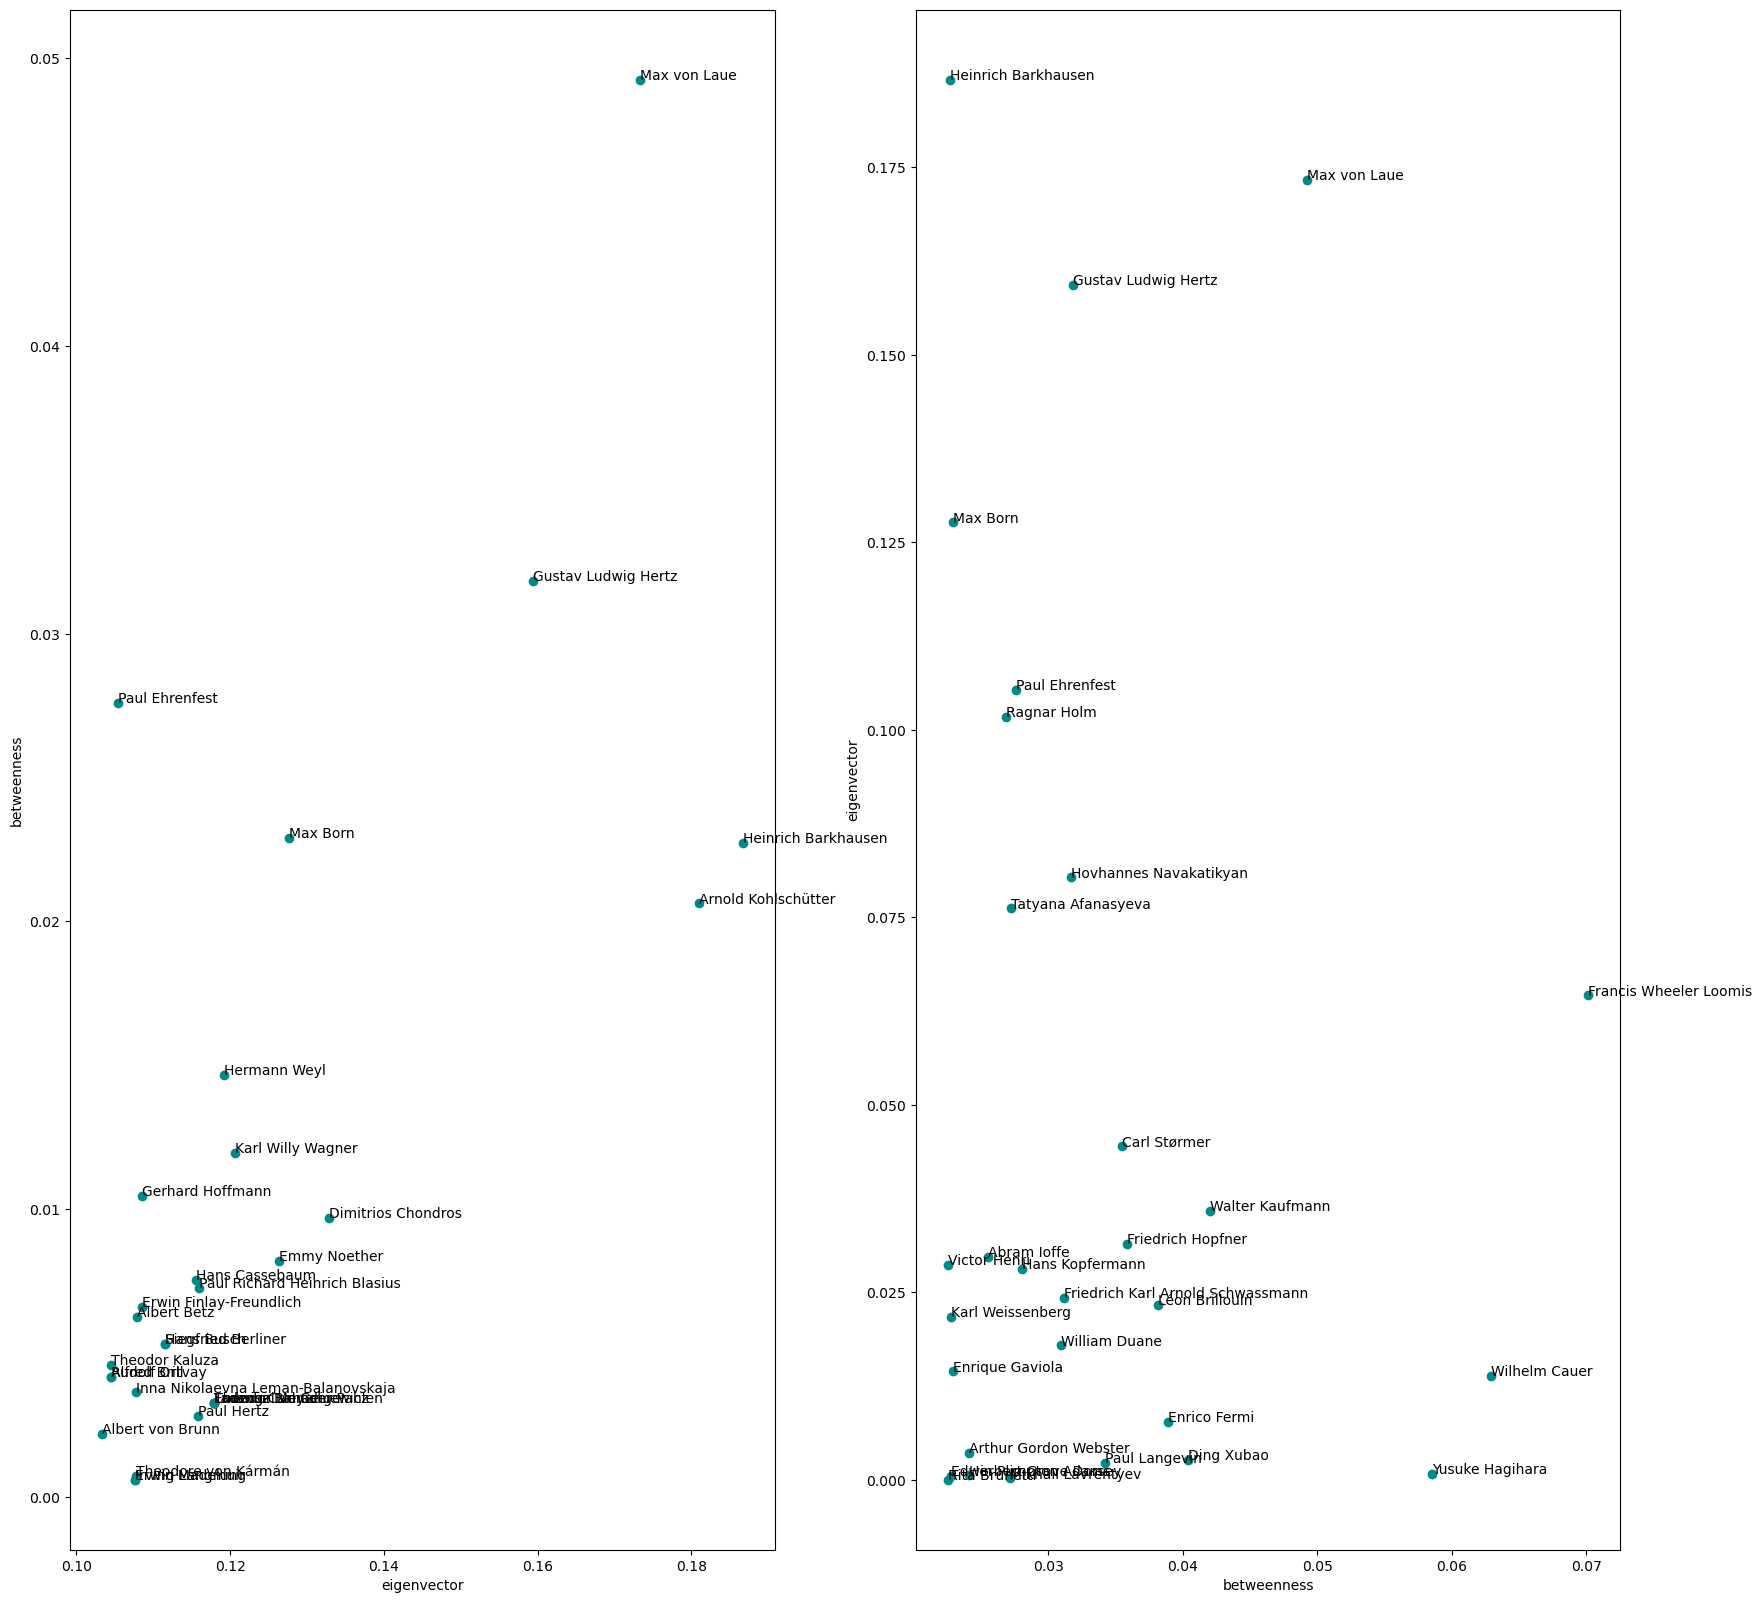

In [162]:
### 



exp_eig = nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]
exp_betw = nodes_df.sort_values(by=['betweenness', 'eigenvector'], ascending=False).iloc[:30]

fig, ax = plt.subplots(1,2,figsize=(20,20) ) #  sharey=True, 

ax[0].scatter(exp_eig['eigenvector'],
            exp_eig['betweenness'],
           marker='o',
           color='DarkCyan'
           )
ax[0].set_xlabel('eigenvector')
ax[0].set_ylabel('betweenness')

for i,row in list(exp_eig[['label', 'eigenvector','betweenness']].iterrows()):
    ax[0].annotate(row['label'],(row['eigenvector'], row['betweenness']),
                 fontsize=10)
    

ax[1].scatter(exp_betw['betweenness'],
            exp_betw['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
ax[1].set_xlabel('betweenness')
ax[1].set_ylabel('eigenvector')

for i,row in list(exp_betw[['label', 'betweenness','eigenvector']].iterrows()):
    ax[1].annotate(row['label'],(row['betweenness'], row['eigenvector']),
                 fontsize=10)



#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [163]:

# Visualize the graph with eigenvector centrality

# Position the nodes
pos = nx.spring_layout(big_ppG, k=0.2)

#node_size = [e[1]*500+10 for e in le]
degrees = [d[1] for d in big_ppG.degree()]
max_degree = max(degrees)
print(max_degree)


cmap = plt.get_cmap('Dark2')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Draw the nodes and edges
#nx.draw_networkx_nodes(big_ppG, pos, ax=ax)
nx.draw_networkx_edges(big_ppG, pos, ax=ax)

# Create the ellipses
for node in big_ppG.nodes():
    width = big_ppG.nodes[node]['eigenvector']*0.7
    height = big_ppG.nodes[node]['betweenness']*0.7
    x, y = pos[node]
    degree = big_ppG.degree(node)
    color = cmap(degree / max_degree)
    ellipse = patches.Ellipse((x, y), width, height, alpha=0.5, facecolor=color)
    ax.add_patch(ellipse)
nx.draw_networkx_labels(big_ppG, pos) # ,  horizontalalignment='left'
# Set the limits and labels
#ax.set_xlim(min(pos.values(), key=lambda x: x[0])[0] - 10, max(pos.values(), key=lambda x: x[0])[0] + 10)
#ax.set_ylim(min(pos.values(), key=lambda x: x[1])[1] - 10, max(pos.values(), key=lambda x: x[1])[1] + 10)
ax.set_title('Ellipse Plot of NetworkX Graph')


plt.show()

KeyboardInterrupt: 

In [110]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    2630.00000000000000000000
mean        0.00192191632693349814
std         0.00465346111880244294
min         0.00000000000000000000
25%         0.00000000000000000000
50%         0.00038022802681483261
75%         0.00176373367301171534
max         0.07014418859794173400
dtype: object


In [111]:
### 

g = big_ppG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [112]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

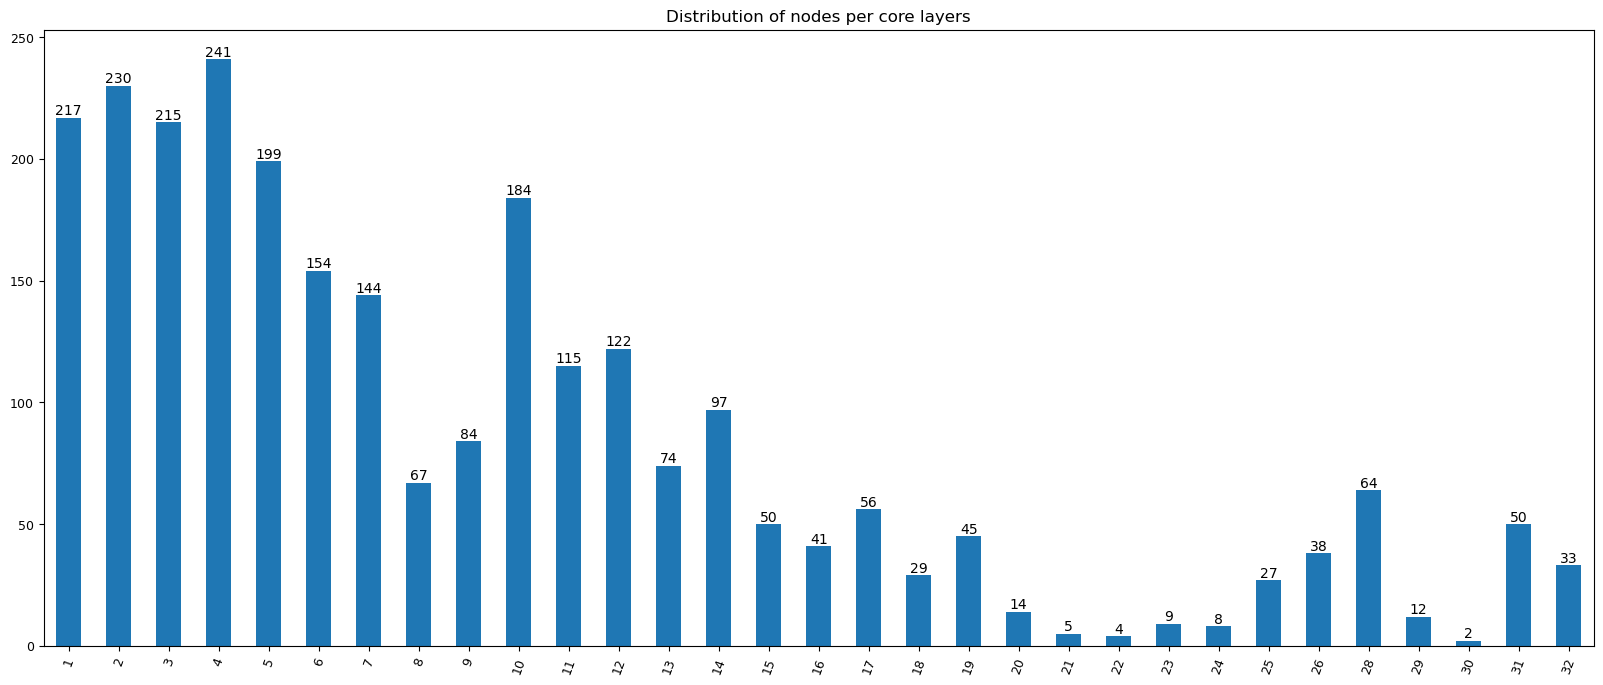

In [113]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [114]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

895 ['http://www.wikidata.org/entity/Q3608048', 'http://www.wikidata.org/entity/Q100935165', 'http://www.wikidata.org/entity/Q104518937']


In [115]:
naf.basic_graph_properties(big_ppG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2630,
 'number_of_edges': 19309,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.005585260627658451}


In [116]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 895,
 'number_of_edges': 12111,
 '------': '------',
 'is connected': False,
 'components': 2,
 'density': 0.030272580705635335}


In [117]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

0.018390452432958743


In [118]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

{'http://www.wikidata.org/entity/Q67717': '', 'http://www.wikidata.org/entity/Q18910428': '', 'http://www.wikidata.org/entity/Q57125': '', 'http://www.wikidata.org/entity/Q6216674': '', 'http://www.wikidata.org/entity/Q64839': '', 'http://www.wikidata.org/entity/Q94820930': '', 'http://www.wikidata.org/entity/Q4342526': '', 'http://www.wikidata.org/entity/Q112596': '', 'http://www.wikidata.org/entity/Q77920': '', 'http://www.wikidata.org/entity/Q15433351': '', 'http://www.wikidata.org/entity/Q711452': '', 'http://www.wikidata.org/entity/Q44703029': '', 'http://www.wikidata.org/entity/Q59631874': '', 'http://www.wikidata.org/entity/Q51844318': '', 'http://www.wikidata.org/entity/Q1305300': '', 'http://www.wikidata.org/entity/Q18631748': '', 'http://www.wikidata.org/entity/Q4224761': '', 'http://www.wikidata.org/entity/Q233355': '', 'http://www.wikidata.org/entity/Q723533': '', 'http://www.wikidata.org/entity/Q6793999': '', 'http://www.wikidata.org/entity/Q1679194': '', 'http://www.wikid

#### Egograph based on eigenvector

In [119]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

0.11787755848725968


In [120]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

11 http://www.wikidata.org/entity/Q60264


In [121]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

['http://www.wikidata.org/entity/Q6216674', 'http://www.wikidata.org/entity/Q94820930']


In [122]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 830,
 'number_of_edges': 8075,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.023471449125815686}


In [123]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q18910428',
  {'betweenness': 0.0001191118637960184,
   'birthYear': 1877,
   'degree': 16,
   'eigenvector': 8.787578476150987e-05,
   'label': 'Edward C. Phillips'}),
 ('http://www.wikidata.org/entity/Q18404639',
  {'betweenness': 0.0011947364642706244,
   'birthYear': 1886,
   'degree': 13,
   'eigenvector': 8.200175243619495e-05,
   'label': 'Victor Robertovich Bursian'})]


In [124]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

0.08330252768025403


In [125]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

In [126]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q18910428,Edward C. Phillips,1877,16,0.000088,0.000119
1,http://www.wikidata.org/entity/Q18404639,Victor Robertovich Bursian,1886,13,0.000082,0.001195


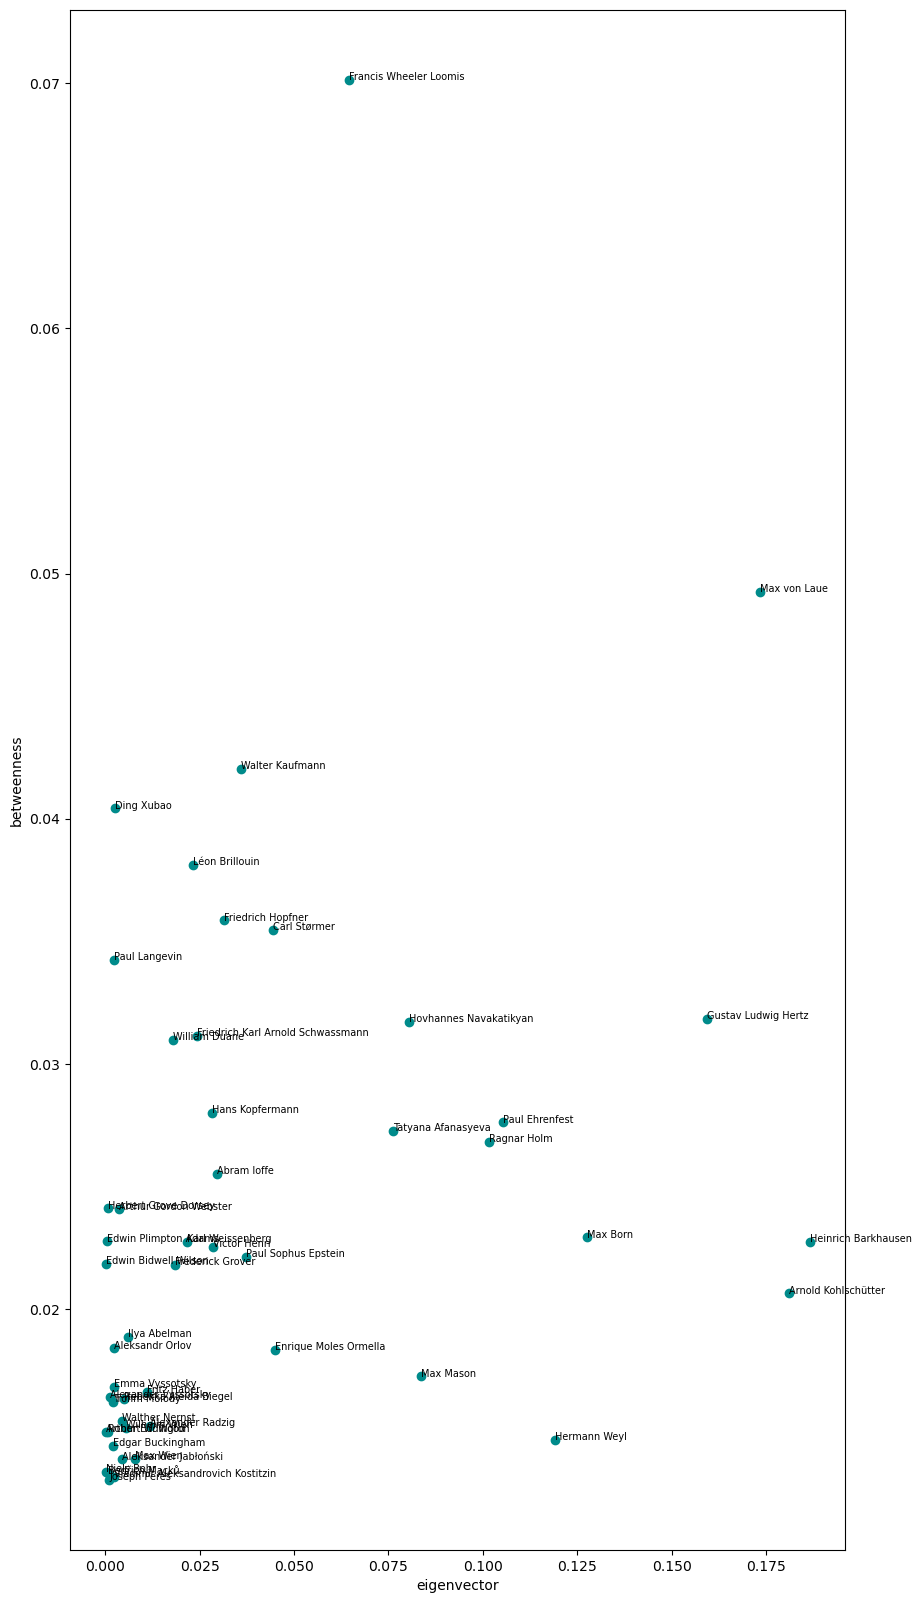

In [128]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:50]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [129]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

50 ['http://www.wikidata.org/entity/Q4342526', 'http://www.wikidata.org/entity/Q77920', 'http://www.wikidata.org/entity/Q1305300']


In [130]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
University of Göttingen                                                 1290
Humboldt University of Berlin                                            364
Ludwig-Maximilian-University in Munich                                   171
Heidelberg University                                                     71
Leipzig University                                                        39
Technische Universität Berlin                                             31
University of Vienna                                                      24
University of Zurich                                                      15
Eötvös Loránd University                                                  15
University of Göttingen|Ludwig-Maximilian-University in Munich            14
Uppsala University                                                         9
Technical University of Munich                                             9
Frederick William University Berlin                                    

# Conclusion

Reste à faire:

* ajouter les poids sur les relations pour calcules les paramètres de centralité
* vérifier s'il y a une correlation entre prix obtenus et centralité dans le réseau des études
* vérifier s'il y a correlation entre étudier ensemble et publier ensemble 

### Period 1901-1920

In [ ]:
gr_mer_1901_1920 = gr_mer[(gr_mer.periods_x=='1901-1920')|(gr_mer.periods_y=='1901-1920')].copy(deep=True)
print(len(gr_mer_1901_1920))

In [ ]:
### Distribution of relationships number
print(gr_mer_1901_1920.groupby(by='numberOrgs').size())

In [ ]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1901_1920.to_dict(orient='records')]
print(len(l))

In [ ]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


In [ ]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [ ]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


In [ ]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



In [ ]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



In [ ]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [ ]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

In [ ]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

In [ ]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')
pprint.pprint(list(big_ppG.nodes.data())[:2])

In [ ]:
print([e[1] for e in list(betweenness.items())][:3])

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:100]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])